# Tarea 2: Investigar la Demografía del Cliente

## Introducción

Tras analizar y describir los datos sobre las transacciones del cliente, ahora estamos preparados para conseguir predecir el comportamiento de los clientes. Las preguntas que nos planteamos son:

I) **Edad del Cliente**: ¿Existen diferencias de edad entre los clientes de distintas regiones? Si es así, ¿podemos predecir la edad del cliente en una región basándonos en la demás información? 

II) **Canal**: ¿Hay correlación entre la edad del cliente y si la transacción se realiza de forma online o en tienda física? ¿Pueden otros factores predecir si un cliente comprará online o en tienda? 

III) **Región**: ¿Es posible clasificar las transacciones por región?

IV) **Número de Productos**: ¿Qué papel juega la cantidad de productos comprados? ¿Aparece en el árbol? ¿Por qué o por qué no?

V) **Cantidad Gastada**: ¿Es posible crear un modelo predictivo utilizando la cantidad gastada como variable dependiente?

Adicionalmente se contrastarán algunas hipótesis que se nos plantean:
- Los clientes que compran en tienda son mayores que aquellos que compran de forma online.
- Los clientes de mayor edad gastan más dinero en electrónica que los jóvenes.

Para dar respuesta a todas estas preguntas, dividiremos cada una de las preguntas en los siguientes apartados:

A. **Descripción de los Datos**: aquí se recuperarán algunos resultados del primer entregable que nos den pistas para construir adecuadamente el modelo predictivo. También se añadirá y ampliarán estos resultados descriptivos si el análisis lo requiere. En este apartado se trata de inferir cómo se ve afectada una variable por el resto.

B. **Selección de las variables independientes**: Aplicación del **feature selection**, es decir, se seleccionan las variables independientes que describen el comportamiento de la dependiente. Se aplicará **feature engineering** si fuera necesario, creando nuevas variables a partir de las existentes. Durante este análisis no se considerará dependencia con el número de productos comprados en ningún caso vistos los resultados de la primera tarea, los cuales no mostraban dependencia con las demás variables.

C. **Modelo Predictivo**: aquí prepararemos el modelo predictivo. Para ello escogeremos el algoritmo, optimizaremos sus **hyperparameters**, dividiremos los datos para que el modelo pueda aprender de ellos y comprobaremos la calidad de este. 

C.1. Dividir las muestras en **training** y **testing** para evitar el **overfitting**. Debemos también asegurar que los datos están **estratificados**, es decir, la frecuencia de los datos para cada una de las agrupaciones mantiene la proporción en ambos conjuntos de datos training y testing. Además, se aplicará el **cross-validation** para evitar posibles errores debido a la partición arbitraria de los datos.

C.2. **Selección y Optimización del Modelo**: aquí escogemos el algoritmo o algoritmos que nos permitirán predecir los resultados. Trataremos de optimizar los **hyperparameters** del modelo. Para ello haremos una partición adicional de los datos que vamos a llamar **validation dataset**, lo cual nos permitirá ajustar el modelo sin que este aprenda de los datos *test* evitando así el overfitting. 
    
C.3. Se realizan las predicciones utilizando el grupo de datos testing y se evaluará la calidad del algoritmo mediante los valores de **precision**, **recall** y **f1-score**. También utilizaremos la **matriz de confusión** para resumir los resultados.

C.4. **Conclusiones**: Extraemos las conclusiones de los resultados. 
    
Antes de comenzar, importamos las librerías necesarias:

In [1]:
#Importamos librerías
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
#Leemos los datos
data = pd.read_csv('Demographic_Data.csv')
# Renombramos columnas
data.rename(columns={'in-store': 'In-Store', 'amount': 'Amount', 'age': 'Age', 'items': 'Items', 'region': 'Region'},inplace=True)
#Substituimos valores
data.Region=data.Region.replace({1:'Norte',2:'Sud',3:'Este',4:'Oeste'})
data.head()

In-Store  Age  Items   Amount Region
0         0   37      4   281.03    Sud
1         0   35      2   219.51    Sud
2         1   45      3  1525.70  Oeste
3         1   46      3   715.25   Este
4         1   33      4  1937.50  Norte

### I) Edad del Cliente

Aquí trataremos de comprobar si existe una dependencia de la edad con respecto a las demás variables y crearemos nuestro propio modelo para predecirla.


### **I.A. Descripción de los Datos**

Organizamos los datos para tener una visión global. A continuación mostramos un boxplot con la distribución de edad considerando dependencia con la región, canal y cantidad gastada. Para esta última variable, será necesario discretizar sus valores. Teniendo en cuenta lo visto en la tarea 1, la discretización más razonable es en los rangos siguientes:
- (0, 500]
- (500, 1000]
- (1000, 2000]
- (2000, 3000]

Estos rangos marcaban límites muy claros, pues para región y canal dados, todas las combinaciones tenían transacciones de valor máximo igual a alguno de estos valores.

In [2]:
#Discretizamos la cantidad por rangos
data['Discrete_Amount']=pd.cut(x=data['Amount'], bins = (0,500,1000,2000,3000))
data['Discrete_Amount']=data['Discrete_Amount'].astype(str)
#Convertimos la variable rangos en números enteros para que los algoritmos puedan interpretarla
le = preprocessing.LabelEncoder()
data['Discrete_Amount'].replace('(500, 1000]','(0500, 1000]',inplace=True)
le.fit(data['Discrete_Amount'])
list(le.classes_)
data['Discrete_Amount_int']=le.transform(data['Discrete_Amount'])
#Variable string con los intervalos considerados
Discrete_Amount=['(0, 500]','(0500, 1000]','(1000, 2000]','(2000, 3000]']
data.head()

In-Store  Age  Items   Amount Region Discrete_Amount  Discrete_Amount_int
0         0   37      4   281.03    Sud        (0, 500]                    0
1         0   35      2   219.51    Sud        (0, 500]                    0
2         1   45      3  1525.70  Oeste    (1000, 2000]                    2
3         1   46      3   715.25   Este    (0500, 1000]                    1
4         1   33      4  1937.50  Norte    (1000, 2000]                    2

Con el objetivo de responder a la primera pregunta, graficamos la edad en función de la región:

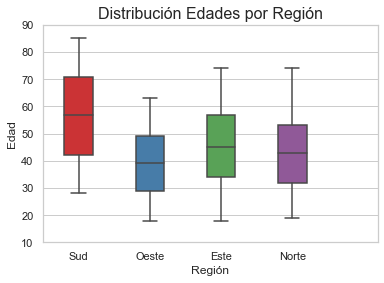

In [3]:
#Valores de la variable In-Store
InStore=['Online','In-Store']
#Se crea figura de tamaño dado
plt.figure(figsize=(6,4))
#Utilizamos la librería seaborn
sns.set(style="whitegrid")
#Diagrama de cajas agrupando por región y modo de compra
ax=sns.boxplot(x="Region", y="Age",data=data, palette="Set1",dodge=True, width=0.4)
#Etiquetas en ejes y leyenda
ax.set(xlabel='Región',ylabel='Edad')
#Ejes
ax.set(ylim=(10, 90))
ax.set(xlim=(-0.5,4.2))
#Título
ax.set_title('Distribución Edades por Región',fontsize=16)
#Mostrar gráfico
plt.show()

Podemos decir que hay ligeras diferencias de edad en función de la región. La que más destaca es la región sud ya que es la que posee una mediana más alta que el resto de regiones. A pesar de ello, todas las cajas son bastante altas y abarcan tal cantidad de edades que no auguran una buena precisión para el modelo. Veamos qué sucede si incluimos el resto de variables:

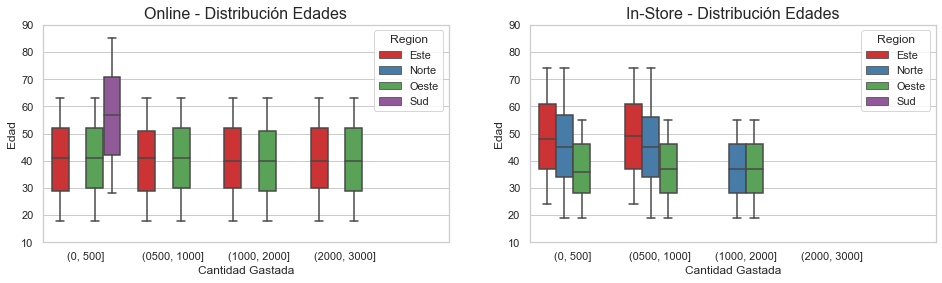

In [4]:
#Valores de la variable In-Store
InStore=['Online','In-Store']
#Incluimos unas filas auxiliares con valores nulos para obtener la leyenda correctamente
new_row = [{'In-Store':0, 'Region':'Norte'},{'In-Store':1, 'Region':'Sud'}]
data_aux=data.append(new_row, ignore_index=True)
#Se crea figura de tamaño dado
plt.figure(figsize=(16,4))
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,3):
    #Plot j: Región j
    plt.subplot(1,2,j)
    #Utilizamos la librería seaborn
    sns.set(style="whitegrid")
    #Diagrama de cajas agrupando por región y modo de compra
    ax=sns.boxplot(x="Discrete_Amount", y="Age",
                    hue="Region",
                    data=data_aux.loc[(data_aux['In-Store']==j-1)].sort_values('Region'), palette="Set1",
                    dodge=True, order=Discrete_Amount)
    #Etiquetas en ejes y leyenda
    ax.set(xlabel='Cantidad Gastada',ylabel='Edad')
    #Ejes
    ax.set(ylim=(10, 90))
    ax.set(xlim=(-0.5,4.2))
    #Título
    ax.set_title(InStore[j-1]+' - Distribución Edades',fontsize=16)
#Mostrar gráfico
plt.show()

Observamos que aún considerando todos los demás parámetros, cada una de las cajas abarca muchos valores. Esto significa que ninguna de ellas se identifica con un rango de edades concreto y bien acotado. Nos interesaría que las cajas fueran lo más pequeñas posible, de forma que dada una cantidad gastada, pudiéramos asignarle una edad con poco margen de error.

Otro paso imprescindible que debemos llevar a cabo es la discretización de la edad dado que el modelo no será capaz de predecir la edad exacta del cliente. Por ello, solo podemos exigirle que sea capaz de asignar la transacción a un cierto rango de edades. Para definir los rangos de edad, vamos a considerar 4 rangos de igual tamaño.

In [5]:
#Definición de los rangos de edad
data['Discrete_Age']=pd.qcut(data['Age'], q=4)
data['Discrete_Age']=data['Discrete_Age'].astype(str)
data['Discrete_Age'].replace(['(17.999, 33.0]','(33.0, 45.0]','(45.0, 56.0]','(56.0, 85.0]'],
                             ['[18, 33]','[34, 45]','[46, 56]','[57, 85]'],inplace=True)
#Variable string con los intervalos considerados
Discrete_Age=np.sort(data['Discrete_Age'].unique())
data.head()

In-Store  Age  Items   Amount Region Discrete_Amount  Discrete_Amount_int  \
0         0   37      4   281.03    Sud        (0, 500]                    0   
1         0   35      2   219.51    Sud        (0, 500]                    0   
2         1   45      3  1525.70  Oeste    (1000, 2000]                    2   
3         1   46      3   715.25   Este    (0500, 1000]                    1   
4         1   33      4  1937.50  Norte    (1000, 2000]                    2   

  Discrete_Age  
0     [34, 45]  
1     [34, 45]  
2     [34, 45]  
3     [46, 56]  
4     [18, 33]

### **I. B. Selección de las Variables Independientes**

Vistos los resultados en el anterior apartado, tendremos en cuenta las siguientes variables independientes:

- **Online/Tienda**
- **Región**
- **Cantidad gastada**

Tengamos en mente que existen algoritmos como el llamado *Decision Tree* que solo es capaz de tratar con variables categoricas si estas son ordinales o binarias. Esto significa que no podemos tener la variable *Region* como input tal y como está definida ahora mismo. Para solventar este problema, debemos crear 4 nuevas variables llamadas Norte, Sud, Este y Oeste. Cada una de estas variables será binaria, tomando un valor 0 o 1 según si la transacción pertenece a la región o no.

En el árbol de decisión podemos escoger 3 de estas 4 variables como features ya que la última siempre será redundante con las demás pero, a pesar de ello, se ha decidido tomar las 4 para facilitar el trabajo al algoritmo. Esto se debe a que si, por ejemplo, escogemos como features las regiones norte, sud y este, y el árbol requiere dividir según la región oeste, necesitará hacer hasta 3 niveles asignando valor 0 a las tres primeras. Si añadimos oeste como feature a pesar de ser redundante, puede realizar esa misma partición en un único nivel.

In [6]:
#Se crean 4 nuevas variables a partir de la variable región para hacerla compatible con el algoritmo
enc = OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(data[['Region']]).toarray())
data = data.join(enc_data)
data.rename(columns={0: 'East', 1: 'North', 2: 'West', 3: 'South'},inplace=True)

Se seleccionan las features y la variable dependiente

In [7]:
#Variable dependiente y features
Features=['Discrete_Amount_int','North','South','East','West','In-Store']
Dependent=["Discrete_Age"]
#Valores de la variable dependiente
var_dep=Discrete_Age
#Datos según features y variable dependiente
X=data[Features]
y=data[Dependent]
data.head()

In-Store  Age  Items   Amount Region Discrete_Amount  Discrete_Amount_int  \
0         0   37      4   281.03    Sud        (0, 500]                    0   
1         0   35      2   219.51    Sud        (0, 500]                    0   
2         1   45      3  1525.70  Oeste    (1000, 2000]                    2   
3         1   46      3   715.25   Este    (0500, 1000]                    1   
4         1   33      4  1937.50  Norte    (1000, 2000]                    2   

  Discrete_Age  East  North  West  South  
0     [34, 45]   0.0    0.0   0.0    1.0  
1     [34, 45]   0.0    0.0   0.0    1.0  
2     [34, 45]   0.0    0.0   1.0    0.0  
3     [46, 56]   1.0    0.0   0.0    0.0  
4     [18, 33]   0.0    1.0   0.0    0.0

### **I. C. Modelo Predictivo**

#### I.C.1. **Split en Training y Testing**

Ahora dividiremos los datos en training y testing. Los parámetros que debemos tener presente son:
- test_size: nos da la proporción con la que se reparten los datos en training y test.
- stratify: necesario para asegurarnos que los datos están estratificados.
- random_state: permite que los resultados sean reproducibles.

Creamos una función que nos haga esta partición y la aplicamos:

In [8]:
def particion(X,y):
    #Proporción de datos test
    ratio_test=0.3
    #Partición training - test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ratio_test, stratify=y, random_state = 0)
    return X_train,X_test,y_train,y_test
X_train,X_test,y_train,y_test=particion(X,y)

#### I.C.2. **Selección del Algoritmo y Optimización**

Crearemos hasta tres modelos predictivos para comparar resultados y ver cuál nos proporciona mejores resultados. Para ello usaremos los siguientes algoritmos:
- **Decision Tree**
- **Random Forest**
- **Gradient Boosting**

Antes de aplicar el algoritmo, trataremos de crear una función que optimice los *hyperparameters* del modelo. A continuación listamos los *hyperparameters* que se han considerado más relevantes y que tendremos en cuenta en la optimización:
- **max_depth**: este parámetro controla la profundidad máxima del árbol. Lo podemos interpretar como el grado de complejidad del árbol. Un mayor valor permitirá al árbol ser más flexible y adaptarse a los datos mejor pero en exceso nos llevará al overfitting. Daremos el rango de valores 4-6.
- **min_samples_leaf**: mínimo de muestras que debe contener un nodo terminal (*leaf node*). Este hyperparameter tiene el efecto de suavizar el modelo, evitando el overfitting. Daremos los valores 1000, 2000 y 4000 como opciones pues corresponden aproximadamente al 2%, 4% y 8% de los datos training respectivamente.
- **min_samples_split**: número mínimo de muestras que debe contener un nodo de decisión (*decision node*). Daremos los mismos valores que en la variable anterior.
- **criterion**: hace referencia a la función que mide la calidad de la división. Puede ser el método *gini* o *entropy*. (solo para *decision tree* y *random forest*).
- **n_estimators**: número de árboles (solo para *GradientBoosting*)
- **Learning Rate**: permite controlar cómo de rápido aprende el modelo y con ello el riesgo de llegar al overfitting (solo para *GradientBoosting*)

Definimos los hyperparameters a optimizar y la lista de posibles valores:

In [9]:
#Max_Depth, profundidad máxima del árbol
md=[4,5,6]
#Min_Samples_Leaf, mínimo número de muestras para un nodo terminal
msl=[1000,2000,4000]
#Min_Samples_split, mínimo número de muestras para un nodo interior
mss=[1000,2000,4000]
#Criterion, criterio para calcular la impureza
crit=['gini','entropy']
#n_estimators, número de árboles
ne=[100, 150]
#Learning Rate, permite controlar cómo de rápido aprende el modelo y con ello el riesgo de llegar al overfitting
lr=[0.01, 0.1]
# Se crea un diccionario de Python con los hyperparameters
param_grid = dict(max_depth=md, min_samples_leaf=msl, min_samples_split=mss, criterion=crit)

Creamos una función que nos elija la combinación de valores más óptima para nuestro modelo aplicando la función GridSearchCV. Dividimos el dataset train en 5 folds, uno de ellos hará de validation set.

In [10]:
#Función que nos selecciona los hyperaparameters más óptimos dada una lista de candidatos
def opt_hyperparameters(model_name,Xt,yt,param_grid):
    #número de folds
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    #Se escoge modelo
    if model_name=='dt':
        # Llamamos el modelo
        model = DecisionTreeClassifier()
        #Se definen los hyperparameters a optimizar
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=kf, n_jobs=-1)
        # Se calculan todas las combinaciones para escoger los mejores parámetros
        grid_result = grid_search.fit(Xt, yt)
        hp_opt=grid_result.best_params_
        hyperparameters=dict(max_depth=hp_opt[list(param_grid.keys())[0]], min_samples_leaf=hp_opt[list(param_grid.keys())[1]],
                             min_samples_split=hp_opt[list(param_grid.keys())[2]],criterion=hp_opt[list(param_grid.keys())[3]])
    elif model_name=='rf':
        # Llamamos el modelo
        model = RandomForestClassifier()
        #Se definen los hyperparameters a optimizar
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=kf, n_jobs=-1)
        # Se calculan todas las combinaciones para escoger los mejores parámetros
        grid_result = grid_search.fit(Xt, np.ravel(yt))
        hp_opt=grid_result.best_params_
        hyperparameters=dict(max_depth=hp_opt[list(param_grid.keys())[0]], min_samples_leaf=hp_opt[list(param_grid.keys())[1]],
                             min_samples_split=hp_opt[list(param_grid.keys())[2]],criterion=hp_opt[list(param_grid.keys())[3]])
    elif model_name=='gb':
        # Llamamos el modelo
        model = GradientBoostingClassifier()
        #Se definen los hyperparameters a optimizar
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=kf, n_jobs=-1)
        # Se calculan todas las combinaciones para escoger los mejores parámetros
        grid_result = grid_search.fit(Xt, np.ravel(yt))
        hp_opt=grid_result.best_params_
        hyperparameters=dict(n_estimators=hp_opt[list(param_grid.keys())[0]], learning_rate=hp_opt[list(param_grid.keys())[1]])
    #Se imprimen los hyperapameters óptimos
    print('Hyperparameters óptimos:')
    for i in range(0,len(hyperparameters)):
        print(list(hyperparameters.keys())[i],': ',list(hyperparameters.values())[i])
    # La función devuelve los parámetros óptimos
    return hyperparameters

A continuación definimos una función que crea el modelo predictivo y nos devuelve los valores predichos. También nos muestra en pantalla los parámetros relacionados con la calidad del modelo:

In [11]:
def model(model_name,X_train,y_train,X_test,y_test,Features,hp):
    #Cross-Validation: definimos número de folds
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    #Se escoge modelo
    if model_name=='dt':
        #Aplicamos el algoritmo
        dt = DecisionTreeClassifier(**hp)
        dt_fit =dt.fit(X_train,y_train)
        #Predicción
        preds =dt_fit.predict(X_test)
        cvs=cross_val_score(dt, X_train, y_train, cv=kf, scoring='accuracy')
        print('Cross Validation Score: ',cvs)
        print('Cross Validation Score Media: ',cvs.mean())
        #Puntuación del modelo
        print(classification_report(y_test, preds))
        #Se muestra árbol
        fig = plt.figure(figsize=(80,20))
        tree = plot_tree(dt, feature_names=Features, filled=True,fontsize=40)
    if model_name=='rf':
        #Aplicamos el algoritmo
        rf = RandomForestClassifier(**hp)
        rf_fit =rf.fit(X_train,np.ravel(y_train))
        #Predicción
        preds =rf_fit.predict(X_test)
        cvs=cross_val_score(rf, X_train, np.ravel(y_train), cv=kf, scoring='accuracy')
        print('Cross Validation Score: ',cvs)
        print('Cross Validation Score Media: ',cvs.mean())
        #Puntuación del modelo
        print(classification_report(y_test, preds))
    if model_name=='gb':
        #Aplicamos el algoritmo
        gb = GradientBoostingClassifier(**hp)
        gb_fit =gb.fit(X_train,np.ravel(y_train))
        #Predicción
        preds =gb_fit.predict(X_test)
        cvs=cross_val_score(gb, X_train, np.ravel(y_train), cv=kf, scoring='accuracy')
        print('Cross Validation Score: ',cvs)
        print('Cross Validation Score Media: ',cvs.mean())
        #Puntuación del modelo
        print(classification_report(y_test, preds))
    return preds

Se define una función que plotea la matriz de confusión:

In [12]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix',fontsize=16)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    fmt = 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('Valores Verdaderos',fontsize=14)
    plt.xlabel('Valores Predecidos',fontsize=14)
    plt.show()

#### I.C.3. Modelo Predictivo

##### Decision Tree

Obtenemos los hyperparameters optimizados para el algoritmo *Decision Tree* aplicando la función creada anteriormente:

In [13]:
hp=opt_hyperparameters('dt',X_train,y_train,param_grid)
#Guardamos los resultados para usarlos posteriormente en el GradientBoosting
hp_tree=hp

Hyperparameters óptimos:
max_depth :  5
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  gini


Obtenemos los resultados relativos al Decision Tree:

Cross Validation Score:  [0.39160714 0.379375   0.37892857 0.38133929 0.39571429]
Cross Validation Score Media:  0.38539285714285715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    [18, 33]       0.37      0.66      0.48      6201
    [34, 45]       0.27      0.16      0.20      6306
    [46, 56]       0.00      0.00      0.00      5543
    [57, 85]       0.45      0.70      0.54      5950

    accuracy                           0.38     24000
   macro avg       0.27      0.38      0.30     24000
weighted avg       0.28      0.38      0.31     24000



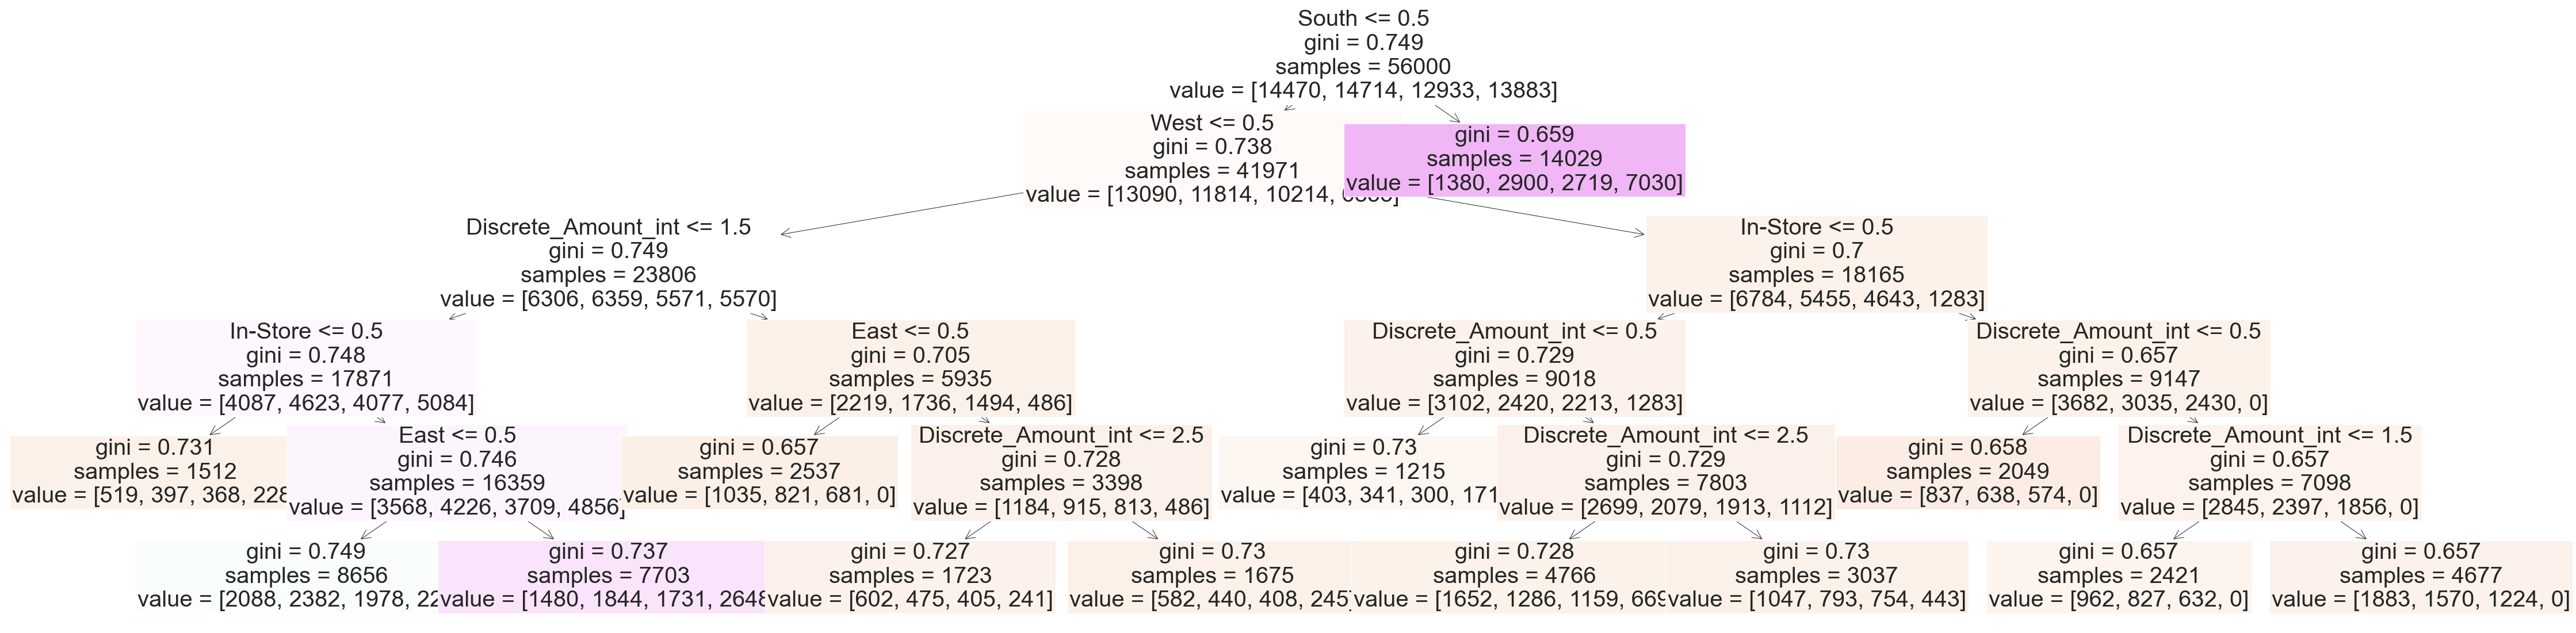

In [14]:
preds=model('dt',X_train,y_train,X_test,y_test,Features,hp)

Matriz de Confusion:

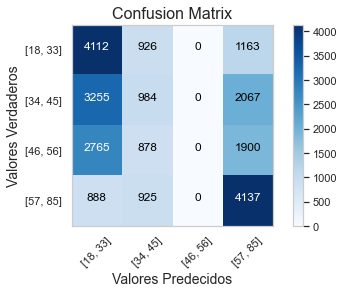

In [15]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

##### Random Forest

Repetimos el procedimiento, esta vez para el algoritmo *random forest*. Encontramos los hyperparameters óptimos:

In [16]:
hp=opt_hyperparameters('rf',X_train,y_train,param_grid)

Hyperparameters óptimos:
max_depth :  4
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  entropy


Obtenemos la calidad del modelo así como los valores que este predice:

In [17]:
preds=model('rf',X_train,y_train,X_test,y_test,Features,hp)

Cross Validation Score:  [0.38866071 0.379375   0.37633929 0.379375   0.39294643]
Cross Validation Score Media:  0.38333928571428577


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    [18, 33]       0.37      0.65      0.47      6201
    [34, 45]       0.27      0.16      0.20      6306
    [46, 56]       0.00      0.00      0.00      5543
    [57, 85]       0.44      0.70      0.54      5950

    accuracy                           0.38     24000
   macro avg       0.27      0.38      0.30     24000
weighted avg       0.27      0.38      0.31     24000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matriz de Confusión:

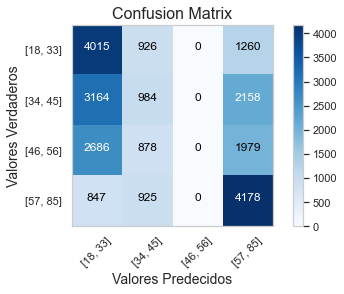

In [18]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

##### Gradient Boosting

Repetimos el procedimiento, esta vez para el algoritmo *gradient boosting*. Por el alto coste computacional de la optimización de todos los hyperparameters, utilizaremos los mismos valores que los obtenidos en el *Decision Tree* y tan solo optimizaremos los parámetros *n_estimators* y *learning_rate*.

In [19]:
# Se crea un diccionario de Python con los hyperparameters
param_grid_gb = dict(n_estimators=ne, learning_rate=lr)  
#Calculamos los parámetros óptimos. Esto puede llevar unos minutos.
hp=opt_hyperparameters('gb',X_train,y_train,param_grid_gb)
#Adjuntamos los hyperparameters del Decision Tree y eliminamos el 'criterion' ya que no aplica en GB
hp.update(hp_tree)
del hp['criterion']

Hyperparameters óptimos:
n_estimators :  150
learning_rate :  0.01


Aplicamos el algoritmo y obtenemos la calidad del modelo así como los valores que predice el modelo

In [20]:
preds=model('gb',X_train,y_train,X_test,y_test,Features,hp)

Cross Validation Score:  [0.39160714 0.379375   0.37892857 0.38133929 0.39571429]
Cross Validation Score Media:  0.38539285714285715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    [18, 33]       0.37      0.66      0.48      6201
    [34, 45]       0.27      0.16      0.20      6306
    [46, 56]       0.00      0.00      0.00      5543
    [57, 85]       0.45      0.70      0.54      5950

    accuracy                           0.38     24000
   macro avg       0.27      0.38      0.30     24000
weighted avg       0.28      0.38      0.31     24000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matriz de confusión

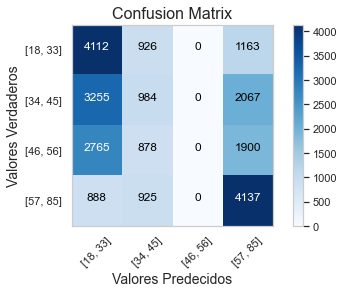

In [21]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

#### I.C.4. **Conclusiones**

Del modelo y la matriz de confusión extraemos las siguientes conclusiones:
- En general, el modelo tiene una precisión muy baja y no es capaz de predecir la edad con garantías.
- Los tres modelos nos proporcionan datos muy parecidos y las conclusiones son las mismas en todos los casos.
- Para los rangos [18,33] y [57,85] tenemos un recall moderado y una baja precisión. Esto significa que es capaz de identificar estos rangos aunque tiende a incluir en ellos muestras de otros rangos.
- El modelo no es capaz de identificar ninguna muestra perteneciente al rango [46,56].
- Para el rango [34,45] tenemos tanto una precisión como un recall muy pobre por lo que tampoco identifica bien este rango.

Respondiendo a las preguntas:

**¿Existen diferencias de edad entre los clientes de distintas regiones?**

Sí existen ligeras diferencias en general, destacando la región sud la cual muestra una media de edad mayor al resto de regiones y, además, es la única que registra transacciones de clientes mayores de 75 años. Aún así, todas las regiones abarcan rangos de edad muy amplios y resulta imposible predecir la edad con precisión.

**¿Podemos predecir la edad del cliente en una región basándonos en la demás información?**

No, el modelo obtenido no es fiable. La precisión es baja para todos los rangos de edad y dos de ellos indican un alto recall. Esto significa que el modelo incluye en esos rangos muchas otras muestras pertenecientes a otros rangos.

### II) Canal

Recordemos la pregunta que se nos plantea: ¿Hay correlación entre la edad del cliente y si la transacción se hace de forma online o en tienda física? ¿Pueden otros factores predecir si un cliente comprará online o en tienda?

Con el objetivo de dar respuesta a la pregunta, realizaremos dos análisis: en primer lugar trataremos de comprobar si existe una dependencia del canal de compra considerando la edad como única feature y, en segundo lugar, añadiremos las demás variables para comprobar si la precisión del modelo predictivo tiene margen de mejora o no.

Dado que se llevarán a cabo estos dos análisis por separado, y con el objetivo de no saturar la respuesta a la pregunta, aquí usaremos tan solo un algoritmo predictivo.


### **II.A. Descripción de los Datos**

Organizamos los datos para tener una visión global. En primer lugar graficamos el número de transacciones para cada edad separando por canal:

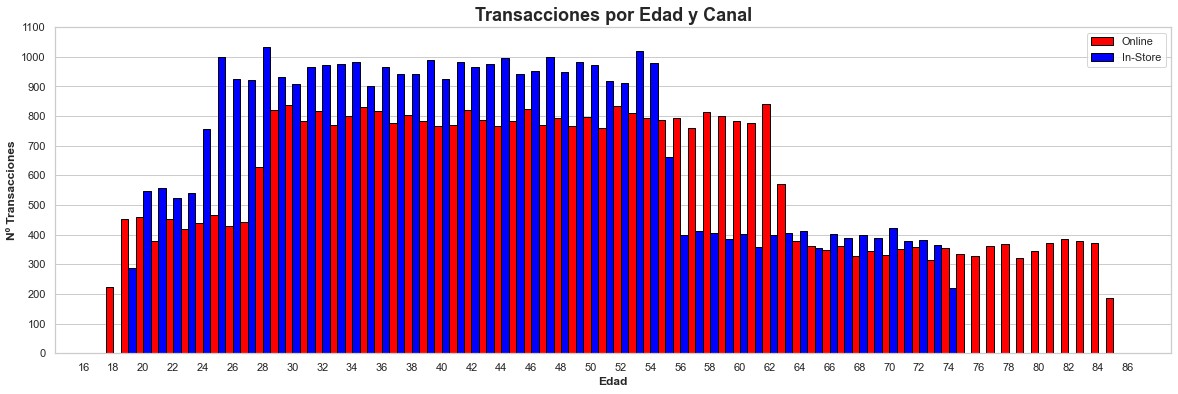

In [22]:
#Se crea figura de tamaño dado
plt.figure(figsize=(20,6))
#Se grafica el plot anterior para cada una de las regiones
#Plot
for i in range (data['Age'].min(),data['Age'].max()+1):
    x_online= data.loc[(data['Age']==i) & (data['In-Store']==0)].shape[0]
    x_inStore=data.loc[(data['Age']==i) & (data['In-Store']==1)].shape[0]
    plt.bar(i-0.25,x_online,color='red',width=0.5,edgecolor='black')
    plt.bar(i+0.25,x_inStore,color='blue',width=0.5,edgecolor='black')
#Etiquetas en los ejes
plt.xticks(np.arange(16,87,2))
plt.yticks(np.arange(0,1101,100))
#Título ejes
plt.xlabel('Edad', fontsize=12,fontweight='bold')
plt.ylabel('Nº Transacciones', fontsize=12,fontweight='bold')
#Título del plot
plt.title('Transacciones por Edad y Canal',fontsize=18,fontweight='bold')
#Leyenda
plt.legend(['Online','In-Store'],loc=0)
#Subgrid solo horizontales
plt.grid(axis='x')
plt.show()

Se puede observar que existen algunos rangos con mayores diferencias que otros:
- Los clientes con 18 años o mayores de 75 inclusive compran exclusivamente online.
- El rango 55-63 tiende a comprar online con mayor frecuencia.
- El rango 24-28 tiende a comprar en tienda con mayor frecuencia.
- El resto de edades muestran más compras en tienda pero las diferencias son pequeñas.
Dado que los casos con tendencias claras son minoria, podemos deducir que dificilmente obtendremos un modelo predictivo de calidad.

Ahora vamos a introducir las demás variables para tratar de ver cuánta información nos proporcionan. Empezamos con la región:

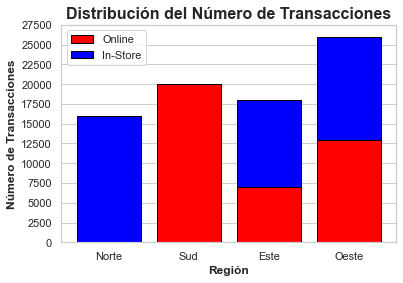

In [23]:
#número de transacciones online por región
Online=[data.loc[(data['In-Store']==0) & (data['Region']=='Norte')].shape[0],
        data.loc[(data['In-Store']==0) & (data['Region']=='Sud')].shape[0],
        data.loc[(data['In-Store']==0) & (data['Region']=='Este')].shape[0],
        data.loc[(data['In-Store']==0) & (data['Region']=='Oeste')].shape[0]]
#número de transacciones en tienda física por región
Tienda=[data.loc[(data['In-Store']==1) & (data['Region']=='Norte')].shape[0],
         data.loc[(data['In-Store']==1) & (data['Region']=='Sud')].shape[0],
         data.loc[(data['In-Store']==1) & (data['Region']=='Este')].shape[0],
         data.loc[(data['In-Store']==1) & (data['Region']=='Oeste')].shape[0]]
#Se grafican los datos
#   en rojo el número de transacciones online
#   en azul el número de transacciones en tienda
plt.bar(np.arange(4),Online,color='red',edgecolor='black')
plt.bar(np.arange(4),Tienda,color='blue',edgecolor='black',bottom=Online)
#Se añaden los nombres de las Regiones en el eje X
plt.xticks(np.arange(4),['Norte','Sud','Este','Oeste'])
#Se ajusta el eje Y
plt.yticks(np.arange(0,27501,2500))
#Título ejes
plt.xlabel('Región', fontsize=12,fontweight='bold')
plt.ylabel('Número de Transacciones', fontsize=12,fontweight='bold')
#Subgrid solo horizontales
plt.grid(axis='x')
#Título gráfico
plt.title('Distribución del Número de Transacciones',fontsize=16,fontweight='bold')
#Se incluye leyenda
plt.legend(['Online','In-Store'],loc=2)
plt.show()

Deducimos que la región será un indicador muy bueno para preveer el canal de la compra. La relación es directa para las regiones norte y sud. Veamos ahora si combinando la región con la edad podemos acabar de desglosar los resultados para las regiones este y oeste:

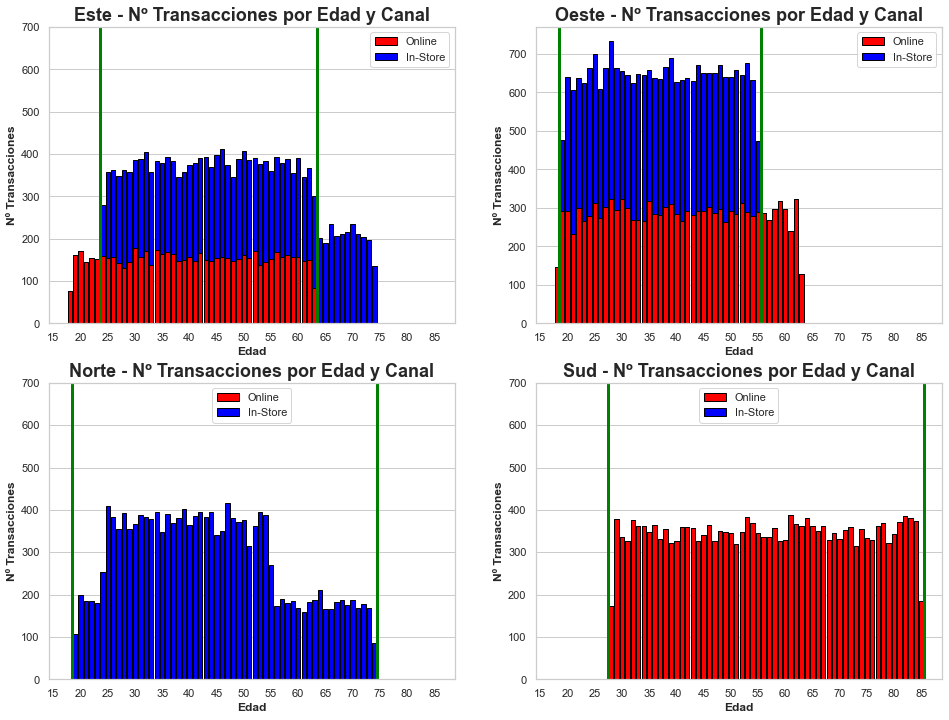

In [24]:
#Se crea figura de tamaño dado
plt.figure(figsize=(16,12))
#Regiones a graficar
regions=['Este','Oeste','Norte','Sud']
#Edades donde trazar linea vertical
vline=[[23.5,63.5],[18.5,55.5],[18.5,74.5],[27.5,85.5]]
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,5):
    #Plot j: Región j
    plt.subplot(2,2,j)
    #Plot
    for i in range (data['Age'].min(),data['Age'].max()+1):
        x_online= data.loc[(data['Age']==i) & (data['In-Store']==0) & (data['Region']==regions[j-1])].shape[0]
        x_inStore=data.loc[(data['Age']==i) & (data['In-Store']==1) & (data['Region']==regions[j-1])].shape[0]
        plt.bar(i,x_online,color='red',edgecolor='black')
        plt.bar(i,x_inStore,color='blue',edgecolor='black',bottom=x_online)
    #Etiquetas en los ejes
    plt.xticks(np.arange(15,86,5))
    plt.yticks(np.arange(0,800,100))
    #Título ejes
    plt.xlabel('Edad', fontsize=12,fontweight='bold')
    plt.ylabel('Nº Transacciones', fontsize=12,fontweight='bold')
    #Título del plot
    plt.title(regions[j-1]+' - Nº Transacciones por Edad y Canal',fontsize=18,fontweight='bold')
    #Leyenda
    plt.legend(['Online','In-Store'],loc=0)
    #Subgrid solo horizontales
    plt.grid(axis='x')
    #Líneas verticales indicando los rangos de edad de interés
    plt.axvline(vline[j-1][0], color='green',linestyle='-',linewidth=3)
    plt.axvline(vline[j-1][1], color='green',linestyle='-',linewidth=3)
plt.show()

Afortunadamente vemos que hay unos rangos donde solo existen compras online o en tienda. Observando los gráficos, podemos partir las muestras en los siguientes rangos (líneas verdes en el gráfico anterior)
- Edad 18
- Edad [19,23]
- Edad [23,27]
- Edad [28,55]
- Edad [56,63]
- Edad [64,74]
- Edad [75,85]

Discretizamos la edad según los rangos que acabamos de ver:

In [25]:
#Discretizamos la edad
data['Discrete_Age']=pd.cut(x=data['Age'], bins = (17,18,23,27,55,63,74,85))
data['Discrete_Age']=data['Discrete_Age'].astype(str)
data['Discrete_Age'].replace(['(17, 18]','(18, 23]','(23, 27]','(27, 55]','(55, 63]','(63, 74]','(74, 85]'],
                             ['18','[19, 23]','[24, 27]','[28, 55]','[56, 63]','[64, 74]','[75, 85]'],inplace=True)
#Variable string con los intervalos considerados
Discrete_Age=np.sort(data['Discrete_Age'].unique())
data.head()

In-Store  Age  Items   Amount Region Discrete_Amount  Discrete_Amount_int  \
0         0   37      4   281.03    Sud        (0, 500]                    0   
1         0   35      2   219.51    Sud        (0, 500]                    0   
2         1   45      3  1525.70  Oeste    (1000, 2000]                    2   
3         1   46      3   715.25   Este    (0500, 1000]                    1   
4         1   33      4  1937.50  Norte    (1000, 2000]                    2   

  Discrete_Age  East  North  West  South  
0     [28, 55]   0.0    0.0   0.0    1.0  
1     [28, 55]   0.0    0.0   0.0    1.0  
2     [28, 55]   0.0    0.0   1.0    0.0  
3     [28, 55]   1.0    0.0   0.0    0.0  
4     [28, 55]   0.0    1.0   0.0    0.0

Asignamos un valor entero a cada rango en orden ascendente empezando por 0. Esto nos permitirá usar esta variable en el algoritmo. Dado que los valores se pueden ordenar, no es necesario hacer el mismo tratamiento que hicimos con la región.

In [26]:
#Asignamoms un valor a cada intervalo de edad para facilitar la división de los rangos en el árbol de decisión
le = preprocessing.LabelEncoder()
le.fit(data['Discrete_Age'])
list(le.classes_)
data['Discrete_Age_int']=le.transform(data['Discrete_Age'])
data.head()

In-Store  Age  Items   Amount Region Discrete_Amount  Discrete_Amount_int  \
0         0   37      4   281.03    Sud        (0, 500]                    0   
1         0   35      2   219.51    Sud        (0, 500]                    0   
2         1   45      3  1525.70  Oeste    (1000, 2000]                    2   
3         1   46      3   715.25   Este    (0500, 1000]                    1   
4         1   33      4  1937.50  Norte    (1000, 2000]                    2   

  Discrete_Age  East  North  West  South  Discrete_Age_int  
0     [28, 55]   0.0    0.0   0.0    1.0                 3  
1     [28, 55]   0.0    0.0   0.0    1.0                 3  
2     [28, 55]   0.0    0.0   1.0    0.0                 3  
3     [28, 55]   1.0    0.0   0.0    0.0                 3  
4     [28, 55]   0.0    1.0   0.0    0.0                 3

A continuación evaluamos la dependencia del canal con la cantidad gastada:

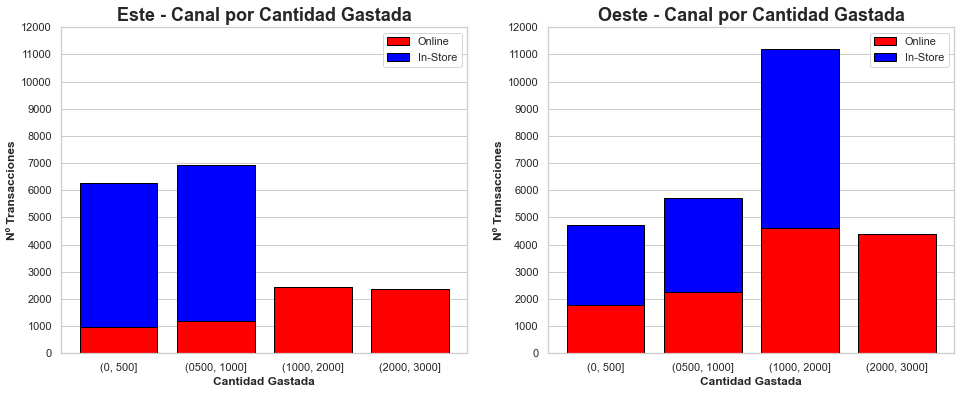

In [27]:
#Se crea figura de tamaño dado
plt.figure(figsize=(16,6))
#Regiones a graficar
regions=['Este','Oeste']
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,3):
    #Plot j: Región j
    plt.subplot(1,2,j)
    #Plot
    for i in range (0,4):
        x_online= data.loc[(data['Discrete_Amount']==Discrete_Amount[i]) & (data['In-Store']==0) & (data['Region']==regions[j-1])].shape[0]
        x_inStore=data.loc[(data['Discrete_Amount']==Discrete_Amount[i]) & (data['In-Store']==1) & (data['Region']==regions[j-1])].shape[0]
        plt.bar(i,x_online,color='red',edgecolor='black')
        plt.bar(i,x_inStore,color='blue',edgecolor='black',bottom=x_online)
    #Etiquetas en los ejes
    plt.xticks([0,1,2,3],Discrete_Amount)
    plt.yticks(np.arange(0,12001,1000))
    #Título ejes
    plt.xlabel('Cantidad Gastada', fontsize=12,fontweight='bold')
    plt.ylabel('Nº Transacciones', fontsize=12,fontweight='bold')
    #Título del plot
    plt.title(regions[j-1]+' - Canal por Cantidad Gastada',fontsize=18,fontweight='bold')
    #Leyenda
    plt.legend(['Online','In-Store'],loc=0)
    #Subgrid solo horizontales
    plt.grid(axis='x')
plt.show()

Los resultados son interesantes ya que para la región este, un gasto mayor de 1000 significa que la transacción se realiza de forma online, mientras que el oeste muestra la misma tendencia para gastos mayores de 2000.

En resumen, tras ver la dependencia con todas las variables, podemos ver que podemos diferenciar el canal para muchos rangos de las distintas variables independientes. Sin embargo, tenemos algunas transacciones para las regiones este y oeste en las que resulta imposible distinguir el canal. Aún así, esperamos una buena precisión global si consideramos las variables región y cantidad gastada y no únicamente la edad.

### **II.B. Selección de las Variables Independientes**

Para responder la pregunta que se nos plantea, haremos dos análisis. En primer lugar trataremos de construir un modelo utilizando tan solo la edad como feature. A continuación, añadiremos las demás variables (región y cantidad gastada) para ver qué información adicional nos porpocionan.

Seleccionamos las variables:

In [28]:
#La variable dependiente será el canal de compra para ambos análisis
Dependent=["In-Store"]
#Valores de la variable dependiente
var_dep=['Online','En Tienda']
#Consideramos la edad como única feature
X_age=data[['Age']]
y=data[Dependent]
#En el segundo análisis, consideramos features todas las demás variables
Features=['Discrete_Amount_int','North','South','East','West','Discrete_Age_int']
X=data[Features]

## **EDAD COMO ÚNICA FEATURE**

### **II.C. Modelo Predictivo**

#### II.C.1. **Split en Training y Testing**

Ahora dividiremos los datos en training y testing.

In [29]:
#Partición training - test
X_train_age, X_test_age, y_train_age, y_test_age = particion(X_age,y)

#### II.C.2. **Selección del Algoritmo y Optimización**

En este caso utilizaremos tan solo el algoritmo *decision tree*. Procederemos de forma parecida al caso anterior, en primer lugar optimizaremos los parámetros:

In [30]:
hp=opt_hyperparameters('dt',X_train_age,y_train_age,param_grid)

Hyperparameters óptimos:
max_depth :  4
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  gini


#### II.C.3. **Modelo Predictivo**

Aplicamos el modelo para obtener su calidad así como los valores predecidos:

Cross Validation Score:  [0.58383929 0.59491071 0.595      0.58732143 0.59089286]
Cross Validation Score Media:  0.590392857142857
              precision    recall  f1-score   support

           0       0.69      0.32      0.44     12000
           1       0.56      0.86      0.68     12000

    accuracy                           0.59     24000
   macro avg       0.63      0.59      0.56     24000
weighted avg       0.63      0.59      0.56     24000



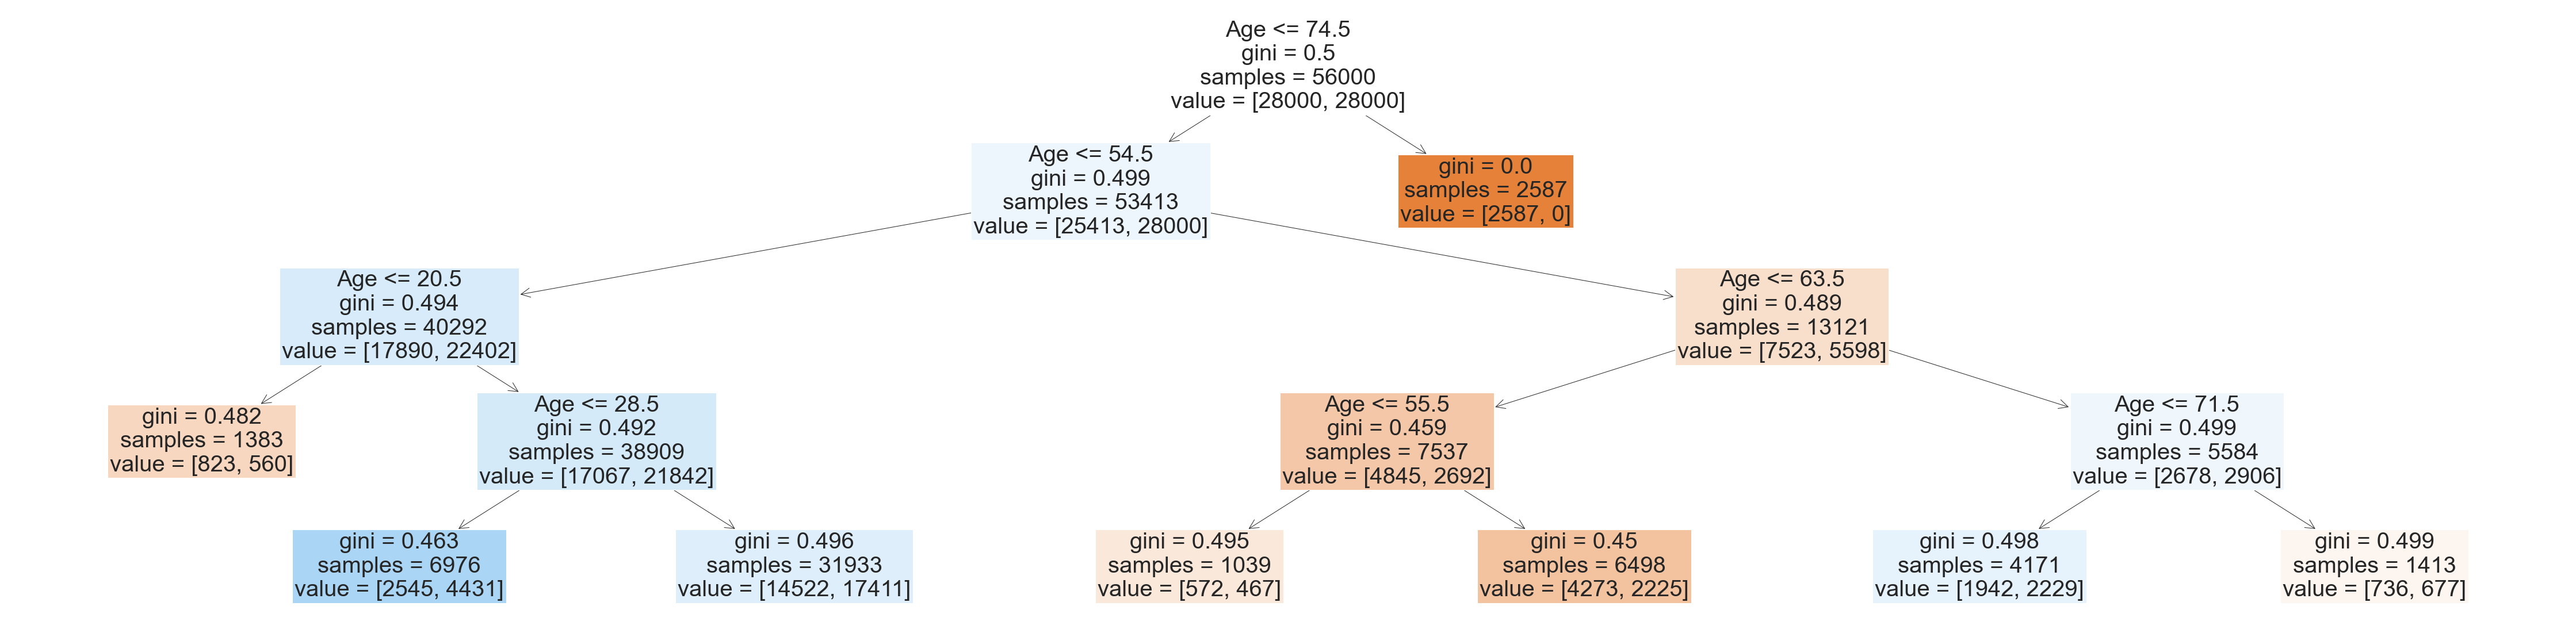

In [31]:
preds=model('dt',X_train_age,y_train_age,X_test_age,y_test_age,['Age'],hp)

Mostramos la matriz de confusión:

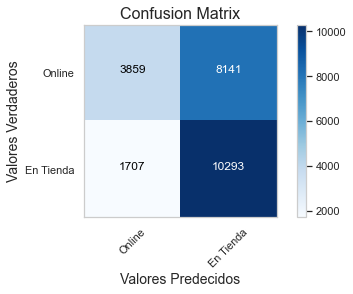

In [32]:
plot_confusion_matrix(confusion_matrix(y_test_age, preds),var_dep)

#### II.C.4. **Conclusiones**

El algoritmo funciona bastante bien en las primeras divisiones. Fijémonos en que el primer split es bajo la condición >74.5. Recordemos del primer apartado, que a partir de 75 años, todas las transacciones se realizaban en el sud y esta región solo registraba compras online. Otros criterios cómo dividir en 63.5 y 54.5 coinciden con los rangos de edad que hemos definido nostros mismos en el apartado de descripción de datos.

A pesar de todo, el modelo no es capaz de alcanzar una gran precisión y tiende a asignar la transacción a compras hechas en tienda como sugiere la baja precisión y el alto recall, así como la propia matriz de confusión.

## **TODAS LAS VARIABLES COMO FEATURES**


### **II.C. Modelo Predictivo**

#### II.C.1. **Split en Training y Testing**

Ahora dividiremos los datos en training y testing:

In [33]:
#Partición training - test
X_train, X_test, y_train, y_test = particion(X,y)

#### II.C.2. **Selección del Algoritmo y Optimización**

Optimizamos los parámetros:

In [34]:
hp=opt_hyperparameters('dt',X_train,y_train,param_grid)

Hyperparameters óptimos:
max_depth :  5
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  gini


#### II.C.3. **Modelo Predictivo**

Aplicamos el modelo para obtener su calidad así como los valores predecidos:

Cross Validation Score:  [0.86794643 0.86330357 0.865625   0.86053571 0.86696429]
Cross Validation Score Media:  0.864875
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     12000
           1       0.79      1.00      0.88     12000

    accuracy                           0.87     24000
   macro avg       0.89      0.87      0.86     24000
weighted avg       0.89      0.87      0.86     24000



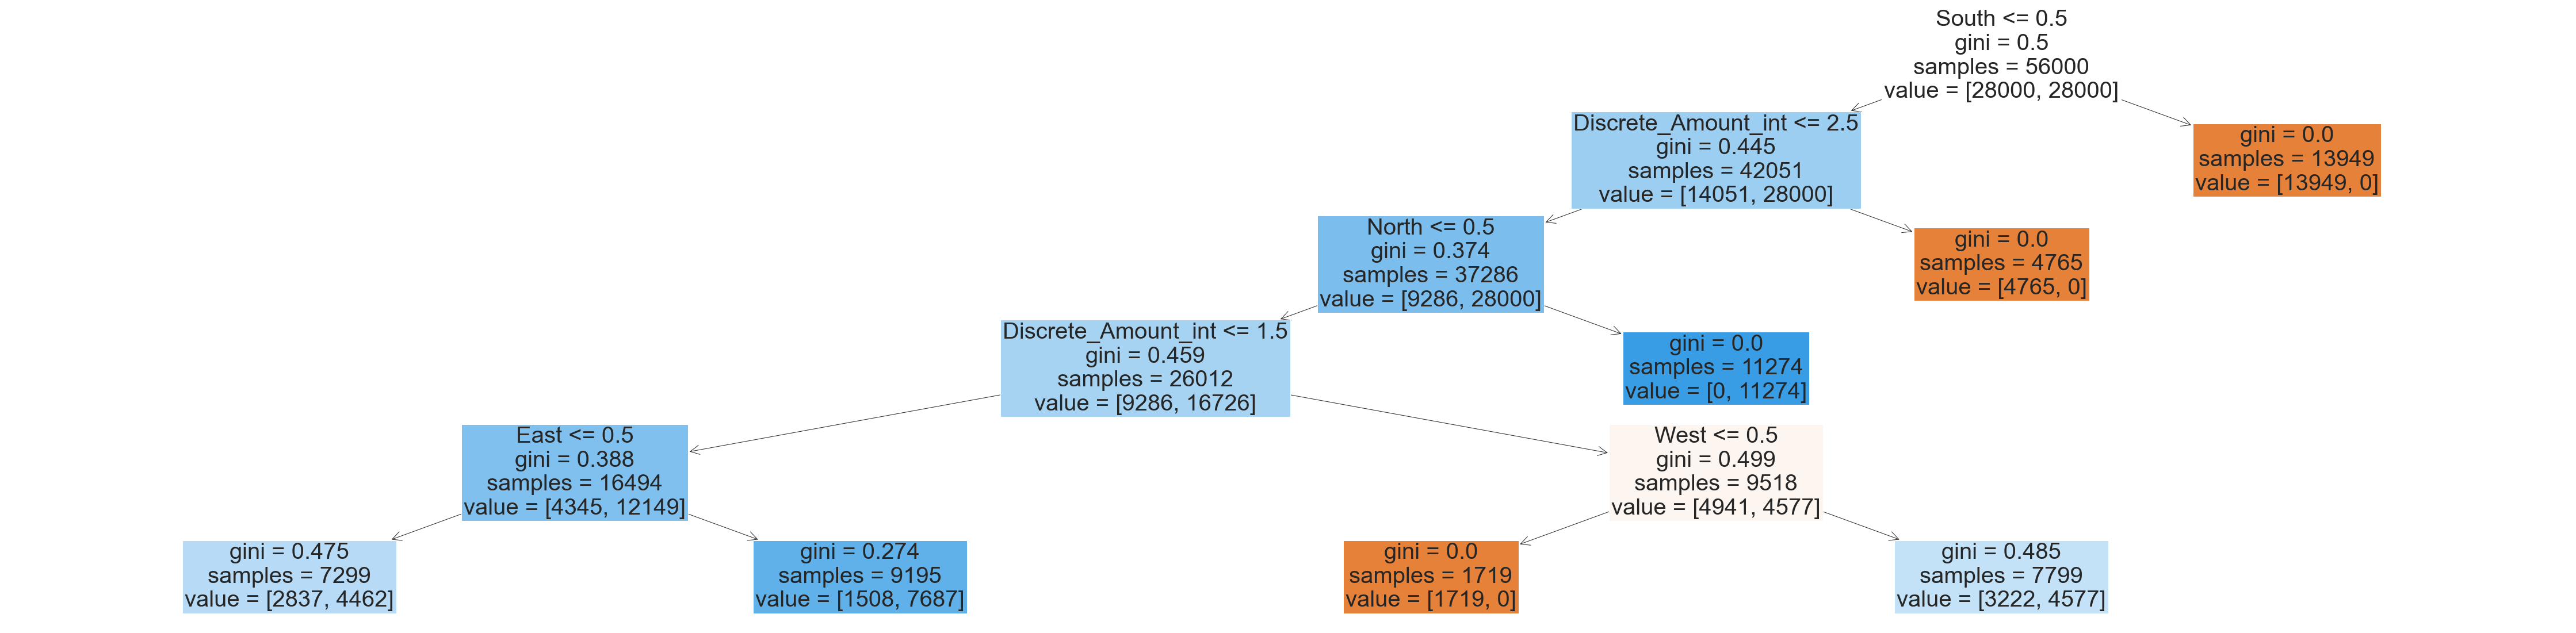

In [35]:
preds=model('dt',X_train,y_train,X_test,y_test,Features,hp)

Mostramos la matriz de confusión:

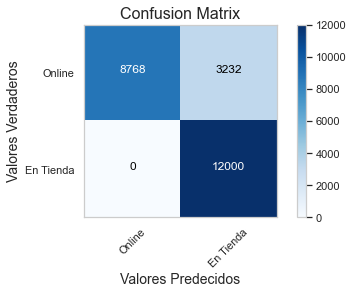

In [36]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

#### II.C.4. **Conclusiones**

Los falsos valores asignados a tienda se han reducido en un factor 2.5 aproximadamente y la precisión con que se asigna al canal online ha subido drásticamente hasta 1.

El canal online muestra una ecxelente precisión y un recall aceptable. Esto significa que el modelo no siempre identifica el canal online pero cuando lo hace, lo hace con mucha confianza.

Para el canal tienda tenemos los valores de precisión y recall cambian sus papeles, ganando protagonismo el segundo. Esto significa que siempre identifica las compras en tienda perfectamente pero también asigna como compras en tienda algunas que realmente se han hecho online.

Este sí puede considerarse un buen modelo. Ahora tenemos los resultados necesarios para responder a la pregunta que se nos plantea:

**¿Hay correlación entre la edad del cliente y si la transacción se realiza de forma online o en tienda física?**

La edad marca algunas tendencias claras para prever el canal de la compra, pero solo para ciertos rangos de edad como los mayores de 75 los cuales solo compran de forma online (primera división que realiza el árbol de decisión). Existen otros colectivos como los comprendidos entre 55-63 y 24-26 que tienden a hacer más compras online y en tienda respectivamente. Sin embargo, en el resto de rangos las compras online y en tienda se reparten de forma muy equitativa y el algoritmo es incapaz de aprender de los datos con certeza. Parece imposible crear un modelo fiable a partir de la edad únicamente. 

**¿Pueden otros factores predecir si un cliente comprará online o en tienda?**

Una vez incluimos las demás features, el modelo mejora substancialmente. La precisión general roza el 90%, las falsas compras en tienda se reducen en un factor 2.5 aproximadamente y se identifican las compras online con una alta garantía. Tenemos por lo tanto un modelo fiable para predecir si la transacción se llevará a cabo de forma online o en tienda.

### III) Región

Es el turno de tratar de predecir la variable región. 


### **III.A. Descripción de los Datos**

Organizamos los datos para tener una visión global y general. De los apartados anteriores vimos:

- El sud solo registraba transacciones de valor inferior a 500. Además, esta concentraba la gran mayoría de transacciones de este valor.
- La edad del cliente medio en el sud era mayor.
- Tan solo las regiones este y oeste tenían transacciones por valor superior a 2000.
- Las regiones norte y sud solo registran transaccines en tienda y online respectivamente.
- Para compras online, solo la región sud registra transacciones de clientes mayores de 65 años.

Como podemos ver, hay muchas condiciones que diferencian la región sud. Podemos esperar un modelo que nos distinga bien la región sud, pero será difícil hacer una buena previsión para las demás regiones.

Realizamos a continuación dos boxplot que visualizan bastante bien los puntos que hemos mencionado aquí.

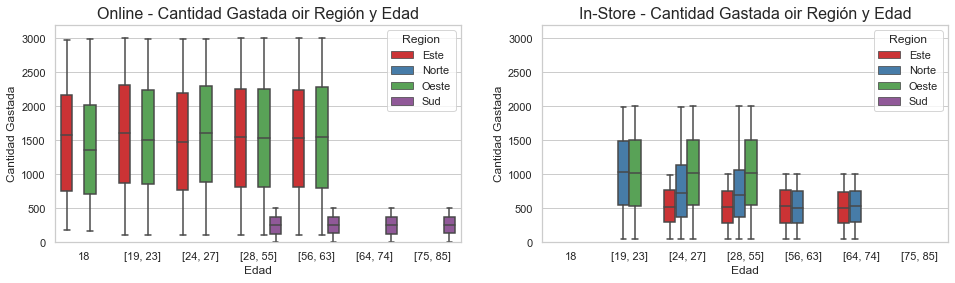

In [37]:
#Incluimos unas filas auxiliares con valores nulos para obtener la leyenda correctamente
new_row = [{'In-Store':0, 'Region':'Norte'},{'In-Store':1, 'Region':'Sud'}]
data_aux=data.append(new_row, ignore_index=True)
#Se crea figura de tamaño dado
plt.figure(figsize=(16,4))
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,3):
    #Plot j: Región j
    plt.subplot(1,2,j)
    #Utilizamos la librería seaborn
    sns.set(style="whitegrid")
    #Diagrama de cajas agrupando por región y modo de compra
    ax=sns.boxplot(x='Discrete_Age', y="Amount",
                    hue="Region",
                    data=data_aux.loc[(data_aux['In-Store']==j-1)].sort_values('Region'), palette="Set1",
                    dodge=True,order=np.sort(data['Discrete_Age'].unique()))
    #Etiquetas en ejes y leyenda
    ax.set(xlabel='Edad',ylabel='Cantidad Gastada')
    #Ejes
    ax.set(ylim=(0, 3200))
    #Título
    ax.set_title(InStore[j-1]+' - Cantidad Gastada oir Región y Edad',fontsize=16)
#Mostrar gráfico
plt.show()

En el diagrama de cajas observamos una diferencia notable para cada rango de edad:
- Edad 19-23: Pasamos a tener compras en tienda en las regiones norte y oeste.
- Edad 24-27: Pasamos a tener compras en tienda en las región este.
- Edad 28-55: Pasamos a tener compras online en las región sud.
- Edad 56-63: Dejamos de tener compras en tienda en las región oeste.
- Edad 64-74: Dejamos de tener compras online en las regiones este y oeste.
- Edad 75-85: No tenemos compras en tienda.

### **III.B. Selección de las Variables Independientes**

Vistos los resultados en el anterior apartado, tendremos en cuenta todas las variables restantes como features a excepción del número de productos comprados:

- **Online/Tienda**
- **Edad**
- **Cantidad gastada**

Se definen las features y la variable dependiente:

In [38]:
#Variable dependiente y features
Features=['Discrete_Amount_int','Discrete_Age_int','In-Store']
Dependent=['Region']
X=data[Features]
y=data[Dependent]
#Valores de la variable dependiente
var_dep=np.sort(data['Region'].unique())

### **III.C. Modelo Predictivo**

#### III.C.1. **Split en Training y Testing**

Ahora dividiremos los datos en training y testing manteniendo los parámetros de los demás apartados:

In [39]:
#Partición training - test
X_train, X_test, y_train, y_test = particion(X, y)

#### III.C.2. **Selección del Algoritmo y Optimización**

Crearemos hasta dos modelos predictivos para comparar resultados y ver cuál nos proporciona mejores resultados:
- **Decision Tree**
- **Random Forest**

Como ya hemos hecho anteriormente, antes de aplicar el algoritmo, optimizaremos los *hyperaparameters* para ambos algoritmos:

In [40]:
#Para decision tree
hp_dt=opt_hyperparameters('dt',X_train,y_train,param_grid)

Hyperparameters óptimos:
max_depth :  4
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  entropy


In [41]:
#Para random forest
hp_rf=opt_hyperparameters('rf',X_train,y_train,param_grid)

Hyperparameters óptimos:
max_depth :  6
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  gini


#### III.C.3. **Modelo Predictivo**

##### Decision Tree

Aplicamos el algoritmo y vemos la precisión:

Cross Validation Score:  [0.64044643 0.63330357 0.641875   0.63008929 0.630625  ]
Cross Validation Score Media:  0.6352678571428572
              precision    recall  f1-score   support

        Este       0.56      0.23      0.32      5400
       Norte       0.42      0.49      0.45      4800
       Oeste       0.63      0.75      0.68      7800
         Sud       0.88      1.00      0.94      6000

    accuracy                           0.64     24000
   macro avg       0.62      0.62      0.60     24000
weighted avg       0.63      0.64      0.62     24000



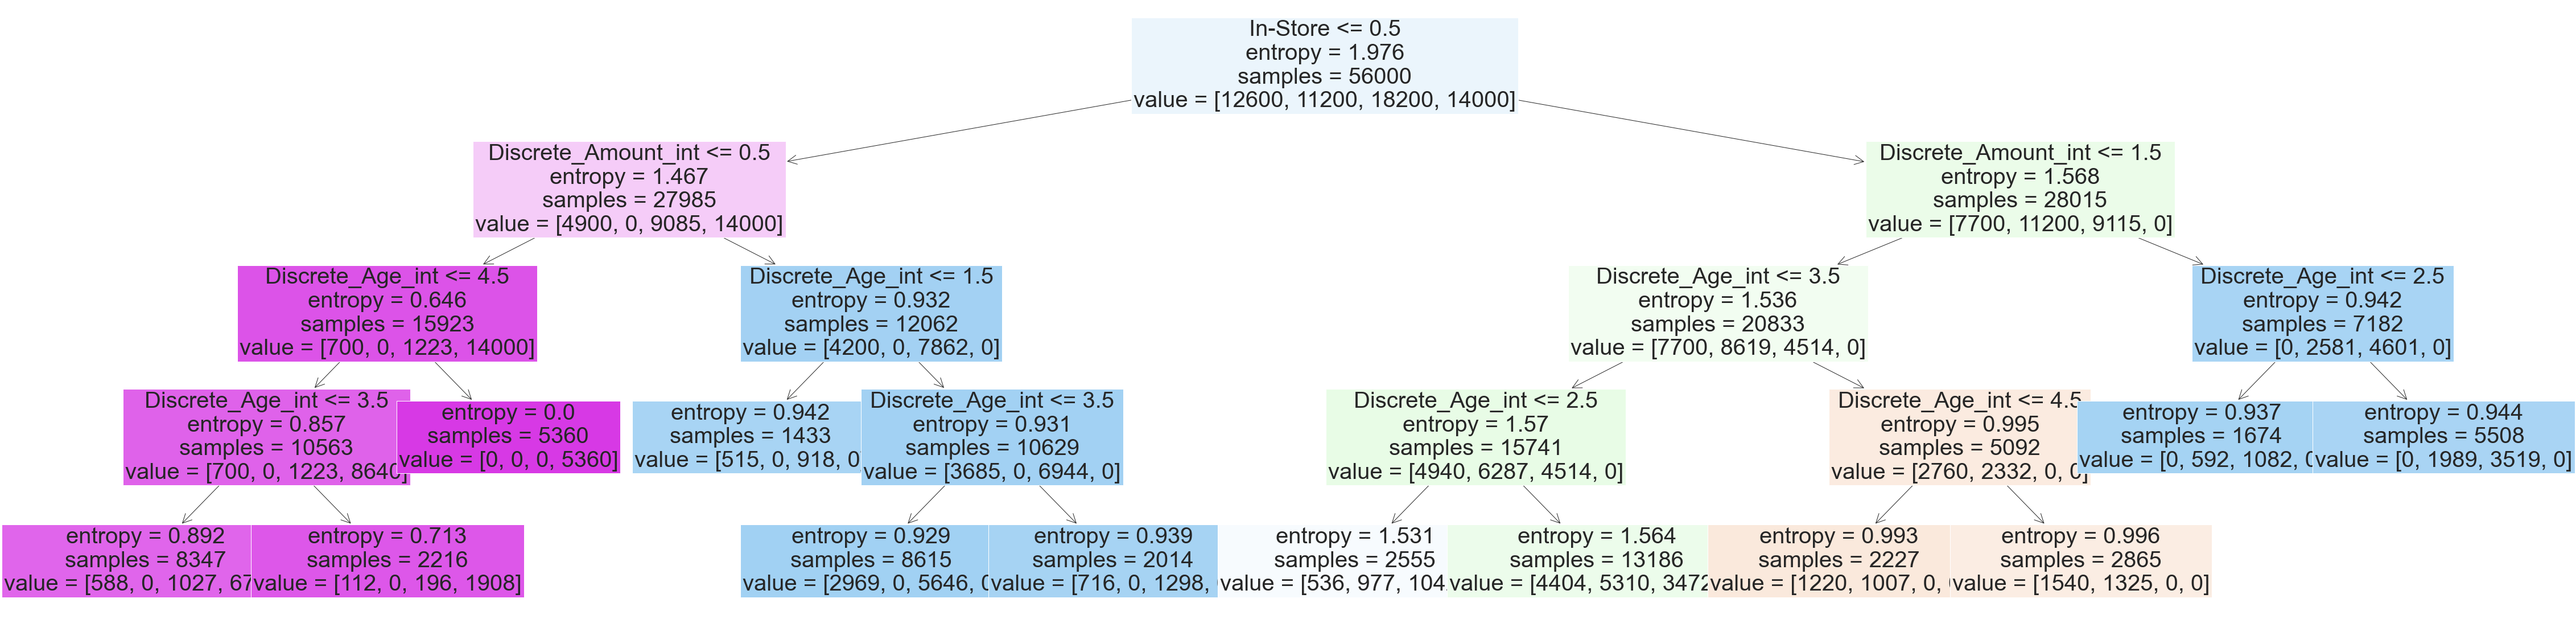

In [42]:
preds=model('dt',X_train,y_train,X_test,y_test,Features,hp_dt)

Visualizamos la matriz de confusión:

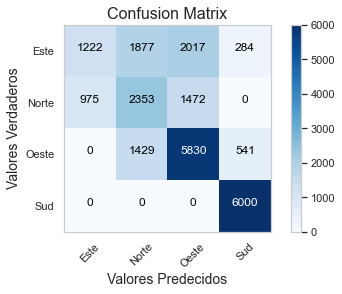

In [43]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

##### Random Forest

Aplicamos el algoritmo y vemos la precisión:

In [44]:
preds=model('rf',X_train,y_train,X_test,y_test,Features,hp_rf)

Cross Validation Score:  [0.64026786 0.63392857 0.64223214 0.63258929 0.62928571]
Cross Validation Score Media:  0.6356607142857144
              precision    recall  f1-score   support

        Este       0.56      0.23      0.32      5400
       Norte       0.42      0.55      0.47      4800
       Oeste       0.65      0.72      0.68      7800
         Sud       0.88      1.00      0.94      6000

    accuracy                           0.65     24000
   macro avg       0.63      0.62      0.60     24000
weighted avg       0.64      0.65      0.62     24000



Visualizamos la matriz de confusión:

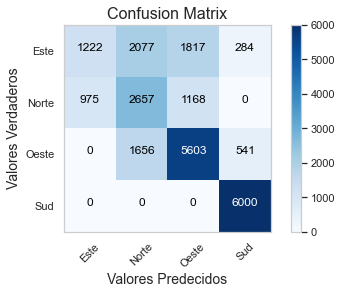

In [45]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

#### III.C.4. **Conclusiones**

Recordemos la pregunta que se nos planteaba:

**¿Es posible clasificar las transacciones por región?**

Como habíamos supuesto, el modelo es capaz de predecir aquellas transacciones que se dan en el sud con muy buena puntuación y, en menor medida, las dadas en la región oeste. El modelo es capaz de identificar todas las transacciones que se dan en el sud (recall = 100%) aunque la precisión no es exacta (88%), es decir, identifica como transacciones del sud algunas que pertenecen a otras regiones.

Para la región oeste, tenemos resultados al límite de los que podríamos considerar como aceptables. Tenemos una precisión del 65% y un recall del 70%. Esto es debido a que la región oeste se diferencia del este para aquellas transacciones hechas en tienda por valor de entre 1000 y 2000. En cambio, los datos no permiten aislar la región este de ninguna forma. La región norte, aunque tampoco se puede aislar completamente, se limita a vender en tienda física por lo que acota más los resultados. Además, recordemos que la región oeste es la región que más transacciones registra, por lo que el modelo tiende a asignar los datos a esta región.

En cuanto a la comparación de los dos algoritmos (Decision Tree y Random Forest), podemos decir que los resultados son muy similares y las conclusiones no cambian.

### IV) Número de Productos

En cuánto al número de productos, describiremos los resultados que ya obtuvimos en la tarea 1. De estos resultados ya concluimos que esta variable no estaba ligada a ninguna otra. Los resultados son tan evidentes que no nos extenderemos realizando el análisis predictivo. Aún así, veremos algunos gráficos para ver cómo se distribuye en función de las otras y justificar así esta decisión.


### **IV.A. Descripción de los Datos**

Organizamos los datos y los visualizamos. Mostramos el número de productos en función de las demás variables. Primero para la cantidad discretizada y después para la edad también discretizada:

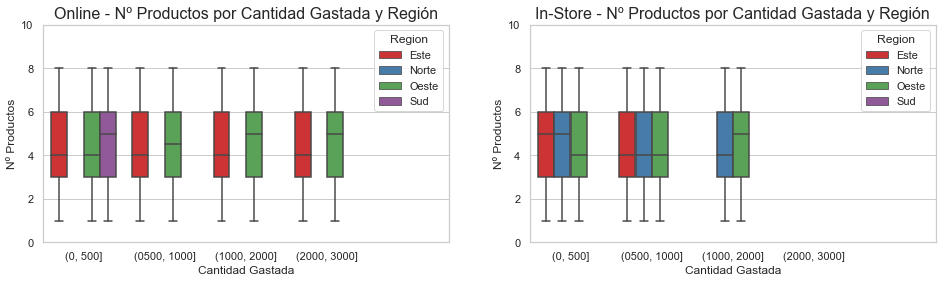

In [46]:
#Incluimos unas filas auxiliares con valores nulos para obtener la leyenda correctamente
new_row = [{'In-Store':0, 'Region':'Norte'},{'In-Store':1, 'Region':'Sud'}]
data_aux=data.append(new_row, ignore_index=True)
#Se crea figura de tamaño dado
plt.figure(figsize=(16,4))
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,3):
    #Plot j: Región j
    plt.subplot(1,2,j)
    #Utilizamos la librería seaborn
    sns.set(style="whitegrid")
    #Diagrama de cajas agrupando por región y modo de compra
    ax=sns.boxplot(x="Discrete_Amount", y="Items",
                    hue="Region",
                    data=data_aux.loc[(data_aux['In-Store']==j-1)].sort_values('Region'), palette="Set1",
                    dodge=True,order=['(0, 500]','(0500, 1000]','(1000, 2000]', '(2000, 3000]'])
    #Etiquetas en ejes y leyenda
    ax.set(xlabel='Cantidad Gastada',ylabel='Nº Productos')
    #Ejes
    ax.set(ylim=(0, 10))
    ax.set(xlim=(-0.5,4.5))
    #Título
    ax.set_title(InStore[j-1]+' - Nº Productos por Cantidad Gastada y Región',fontsize=16)
#Mostrar gráfico
plt.show()

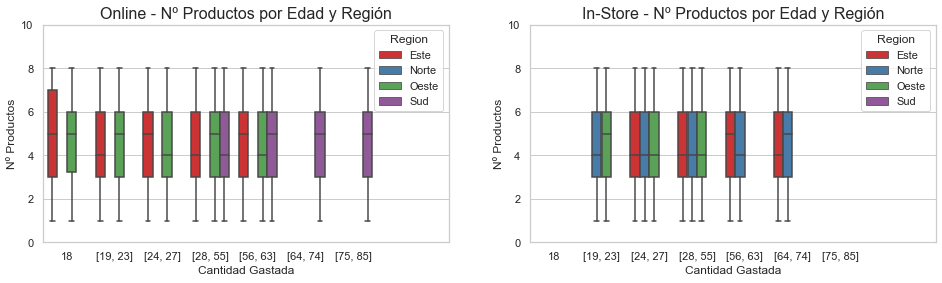

In [47]:
#Se crea figura de tamaño dado
plt.figure(figsize=(16,4))
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,3):
    #Plot j: Región j
    plt.subplot(1,2,j)
    #Utilizamos la librería seaborn
    sns.set(style="whitegrid")
    #Diagrama de cajas agrupando por región y modo de compra
    ax=sns.boxplot(x="Discrete_Age", y="Items",
                    hue="Region",
                    data=data_aux.loc[(data_aux['In-Store']==j-1)].sort_values('Region'), palette="Set1",
                    dodge=True,order=np.sort(data['Discrete_Age'].unique()))
    #Etiquetas en ejes y leyenda
    ax.set(xlabel='Cantidad Gastada',ylabel='Nº Productos')
    #Ejes
    ax.set(ylim=(0, 10))
    ax.set(xlim=(-0.5,8))
    #Título
    ax.set_title(InStore[j-1]+' - Nº Productos por Edad y Región',fontsize=16)
#Mostrar gráfico
plt.show()

Como podemos ver, no hay correlación ninguna con ninguna variable y todas las cajas abarcan todos los valores (de 1 a 8 productos). Este es el motivo por el que ni siquiera se ha considerado en los demás modelos. Si se considerase, no hubiera aparecido en el árbol ya que el algoritmo calcula la partición que le proporciona mayor información y esta variable no proporciona ninguna.

No se ampliarán los demás apartados ya que no tiene sentido crear un algoritmo para predecir esta variable.

### V) Cantidad Gastada

En este punto trataremos de crear un modelo predictivo de la cantidad gastada. 


### **V.A. Descripción de los Datos**

Organizamos los datos para tener una visión global y general. De los apartados anteriores podemos decir:

- En general, el gasto por transacción tiene un límite muy bien definido de 3000.
- Por regiones y canal, estos límites cambian dejando en evidencia los rangos en los que debemos discretizar la variable.
        - En la región sud el máximo es 500.
        - En la región norte el máximo es 2000
        - En la región este y oeste el máximo es 3000 para compras online
        - En la región este el máximo es 1000 para compras en tienda
        - En la región oeste el máximo es 2000 para compras en tienda

Representamos los datos dividiendo por rangos de edad en un diagrama de cajas. Utilizaremos los rangos definidos anteriormente. Nos interesa que las cajas sean lo más pequeñas posibles para centrar los valores en el rango más estrecho posible, de forma que sea fácil predecir los valores.

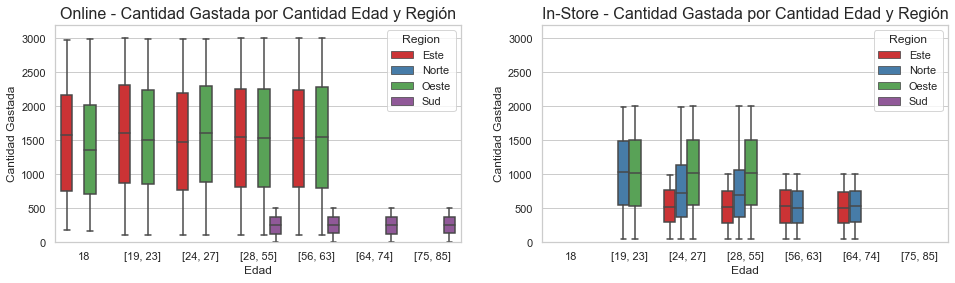

In [48]:
#Incluimos unas filas auxiliares con valores nulos para obtener la leyenda correctamente
new_row = [{'In-Store':0, 'Region':'Norte'},{'In-Store':1, 'Region':'Sud'}]
data_aux=data.append(new_row, ignore_index=True)
#Se crea figura de tamaño dado
plt.figure(figsize=(16,4))
#Se grafica el plot anterior para cada una de las regiones
for j in range(1,3):
    #Plot j: Región j
    plt.subplot(1,2,j)
    #Utilizamos la librería seaborn
    sns.set(style="whitegrid")
    #Diagrama de cajas agrupando por región y modo de compra
    ax=sns.boxplot(x='Discrete_Age', y="Amount",
                    hue="Region",
                    data=data_aux.loc[(data_aux['In-Store']==j-1)].sort_values('Region'), palette="Set1",
                    dodge=True,order=np.sort(data['Discrete_Age'].unique()))
    #Etiquetas en ejes y leyenda
    ax.set(xlabel='Edad',ylabel='Cantidad Gastada')
    #Ejes
    ax.set(ylim=(0, 3200))
    #Título
    ax.set_title(InStore[j-1]+' - Cantidad Gastada por Cantidad Edad y Región',fontsize=16)
#Mostrar gráfico
plt.show()

La edad nos proporciona algunos patrones adicionales, sobretodo sobre la región norte donde limita el máximo importe por transacción a 1000 para edades mayores de 55. Sin embargo, tampoco resulta ser un indicador que nos dé una distinción precisa. 

La región también nos proporciona información muy valiosa, sobretodo para la región sud, que se diferencia de las demás con claridad y se limita a las transacciones de valor hasta 500.

El mayor problema surge en las regiones este y oeste ya que el diagrama de cajas muestra unas cajas muy altas en compras online, con muchos valores posibles para una región y edad dadas.

### **V.B. Selección de las Variables Independientes**

Las variables que tendremos en cuenta son:

- **Online/Tienda**
- **Edad**
- **Region**

Se definen las features y la variable dependiente:

In [49]:
#Variable dependiente y features
Features=['Discrete_Age_int','In-Store','North','South','East','West']
Dependent=['Discrete_Amount']
X=data[Features]
y=data[Dependent]
#Valores de la variable dependiente
var_dep=Discrete_Amount

### **V.C. Modelo Predictivo**

#### V.C.1. **Split en Training y Testing**

Ahora dividiremos los datos en training y testing:

In [50]:
#Partición training - test
X_train, X_test, y_train, y_test = particion(X, y)

#### V.C.2. **Selección del Algoritmo y Optimización**

Crearemos dos modelos predictivos para comparar resultados y ver cuál nos proporciona mejores resultados. Para ello usaremos los siguientes algoritmos:
- **Decision Tree**
- **Random Forest**

##### Decision Tree

Optimizamos los parámetros

In [51]:
hp_dt=opt_hyperparameters('dt',X_train,y_train,param_grid)

Hyperparameters óptimos:
max_depth :  6
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  gini


##### Random Forest

Optimizamos los parámetros:

In [52]:
hp_rf=opt_hyperparameters('rf',X_train,y_train,param_grid)

Hyperparameters óptimos:
max_depth :  4
min_samples_leaf :  1000
min_samples_split :  1000
criterion :  gini


#### V.C.3. **Modelo Predictivo**

##### Decision Tree

Aplicamos el algoritmo y vemos la precisión:

Cross Validation Score:  [0.57901786 0.57125    0.57723214 0.58178571 0.56928571]
Cross Validation Score Media:  0.5757142857142857
              precision    recall  f1-score   support

    (0, 500]       1.00      0.55      0.71     11046
(0500, 1000]       0.46      0.60      0.52      5750
(1000, 2000]       0.41      0.76      0.54      5179
(2000, 3000]       0.31      0.16      0.21      2025

    accuracy                           0.57     24000
   macro avg       0.55      0.52      0.49     24000
weighted avg       0.69      0.57      0.58     24000



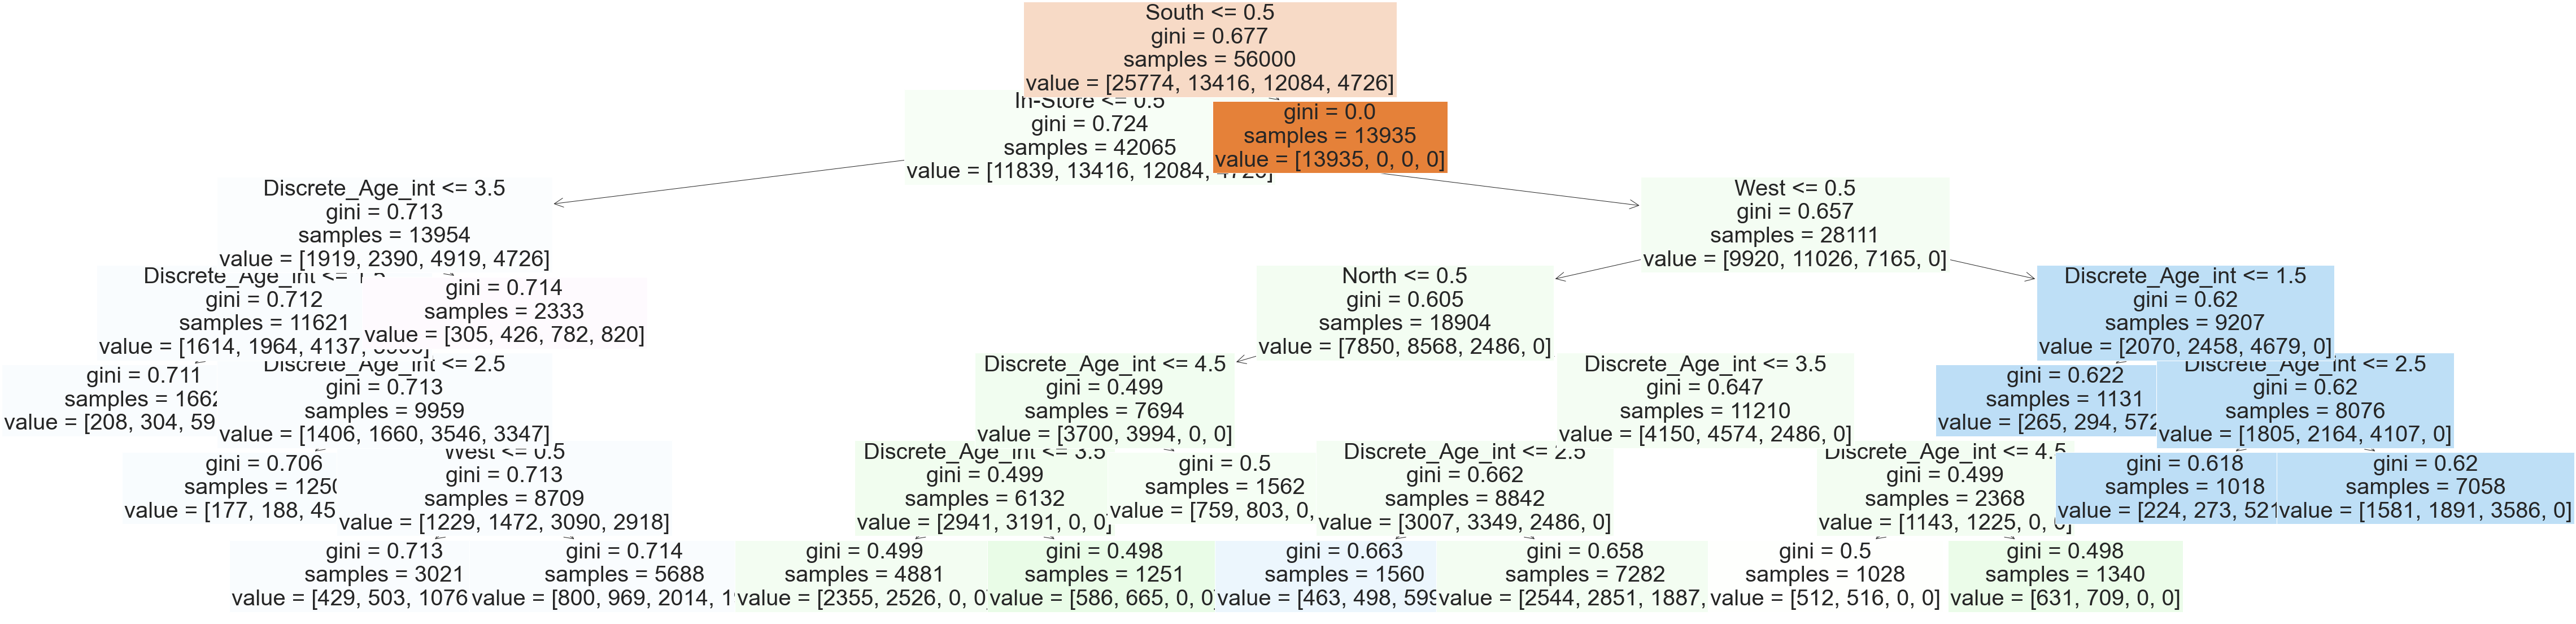

In [53]:
preds=model('dt',X_train,y_train,X_test,y_test,Features,hp_dt)

Visualizamos la matriz de confusión:

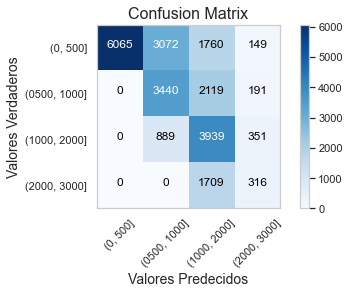

In [54]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

##### Random Forest

Aplicamos ahora el algoritmo random forest:

In [55]:
preds=model('rf',X_train,y_train,X_test,y_test,Features,hp_rf)

Cross Validation Score:  [0.57714286 0.56776786 0.57223214 0.58142857 0.565     ]
Cross Validation Score Media:  0.5727142857142857


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    (0, 500]       1.00      0.55      0.71     11046
(0500, 1000]       0.45      0.64      0.53      5750
(1000, 2000]       0.41      0.78      0.54      5179
(2000, 3000]       0.00      0.00      0.00      2025

    accuracy                           0.57     24000
   macro avg       0.47      0.49      0.44     24000
weighted avg       0.66      0.57      0.57     24000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Visualizamos la matriz de confusión:

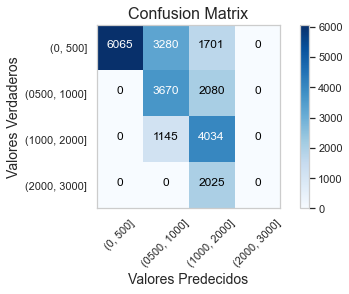

In [56]:
plot_confusion_matrix(confusion_matrix(y_test, preds),var_dep)

#### V.C.4. **Conclusiones**

Recordemos la pregunta que nos planteábamos:

**¿Es posible crear un modelo predictivo utilizando la cantidad gastada como variable dependiente?**

La precisión del modelo es bastante baja en general pero aún así podemos extraer información útil de él. El motivo para afirmar esto es que tenemos una excelente precisión para el rango de gasto entre 0 y 500. La alta precisión junto al bajo recall nos está diciendo que el modelo no será capaz de detectar muy bien este rango de gasto pero cuando lo haga, será muy fiable. Por lo tanto, siempre que este modelo nos diga que el gasto del cliente será entre 0 y 500 podemos confiar en él. 

Para el rango [1000, 2000] tenemos un buen valor de recall. Esto significa que identifica correctamente el rango pero tiende a meter en este mismo rango transacciones que realmente pertenencen a otros.

Así pues la respuesta a la pregunta sería que hemos obtenido un modelo que es capaz de predecir con precisión únicamente las transacciones de valor entre 0 y 500 pero no es capaz de predecir las demás cantidades con precisión.

 ## Resumen y Conclusiones
 
- **Preguntas que plantea Anielle Sherman**

Se recogen aquí las respuestas que ya hemos dado en sus respectivos apartados:
 
 **¿Existen diferencias de edad entre los clientes de distintas regiones?**

Sí existen ligeras diferencias en general, destacando la región sud la cual muestra una media de edad mayor al resto de regiones y, además, es la única que registra transacciones de clientes mayores de 75 años. Aún así, todas las regiones abarcan rangos de edad muy amplios y resulta imposible predecir la edad con precisión.

**¿Podemos predecir la edad del cliente en una región basándonos en la demás información?**

No, el modelo obtenido no es fiable. La precisión es baja para todos los rangos de edad y dos de ellos indican un alto recall. Esto significa que el modelo incluye en esos rangos muchas otras muestras pertenecientes a otros rangos.

**¿Hay correlación entre la edad del cliente y si la transacción se realiza de forma online o en tienda física?**

La edad marca algunas tendencias claras para prever el canal de la compra, pero solo para ciertos rangos de edad como los mayores de 75 los cuales solo compran de forma online (primera división que realiza el árbol de decisión). Existen otros colectivos como los comprendidos entre 55-63 y 24-26 que tienden a hacer más compras online y en tienda respectivamente. Sin embargo, en el resto de rangos las compras online y en tienda se reparten de forma muy equitativa y el algoritmo es incapaz de aprender de los datos con certeza. Parece imposible crear un modelo fiable a partir de la edad únicamente. 

**¿Pueden otros factores predecir si un cliente comprará online o en tienda?**

Una vez incluimos las demás features, el modelo mejora substancialmente. La precisión general roza el 90%, las falsas compras en tienda se reducen en un factor 2.5 aproximadamente y se identifican las compras online con una alta garantía. Tenemos por lo tanto un modelo fiable para predecir si la transacción se llevará a cabo de forma online o en tienda.

- **Otras preguntas planteadas:**

**¿Es posible clasificar las transacciones por región?**

El modelo es capaz de predecir aquellas transacciones que se dan en el sud con muy buena puntuación y, en menor medida, las dadas en la región oeste. El modelo es capaz de identificar todas las transacciones que se dan en el sud (recall = 100%) aunque la precisión no es exacta (88%), es decir, identifica como transacciones del sud algunas que pertenecen a otras regiones.

Para la región oeste, tenemos resultados al límite de los que podríamos considerar como aceptables. Tenemos una precisión del 65% y un recall del 70%. Esto es debido a que la región oeste se diferencia del este para aquellas transacciones hechas en tienda por valor de entre 1000 y 2000. En cambio, los datos no permiten aislar la región este de ninguna forma. La región norte, aunque tampoco se puede aislar completamente, se limita a vender en tienda física por lo que acota más los resultados. Además, recordemos que la región oeste es la región que más transacciones registra, por lo que el modelo tiende a asignar los datos a esta región.

**¿Qué papel juega la cantidad de productos comprados? ¿Aparece en el árbol? ¿Por qué o por qué no?**

No hay correlación ninguna con ninguna variable. Este es el motivo por el que ni siquiera se ha considerado en los demás modelos. Si se considerase, no hubiera aparecido en el árbol ya que el algoritmo calcula la partición que le proporciona mayor información y esta variable no proporciona ninguna.

**¿Es posible crear un modelo predictivo utilizando la cantidad gastada como variable dependiente?**

La precisión del modelo es bastante baja en general pero aún así podemos extraer información útil de él. El motivo para afirmar esto es que tenemos una gran precisión para el rango de gasto entre 0 y 500. La alta precisión junto al bajo recall nos está diciendo que el modelo no será capaz de detectar muy bien este rango de gasto pero cuando lo haga, será muy fiable. Por lo tanto, siempre que este modelo nos diga que el gasto del cliente será entre 0 y 500 podemos confiar en él. 

Así pues la respuesta a la pregunta sería que hemos obtenido un modelo que es capaz de predecir con precisión únicamente las transacciones de valor entre 0 y 500 pero no es capaz de predecir las demás cantidades.

- **Hipótesis planteadas por Martin Goodrich:**

Adicionalmente se contrastarán algunas hipótesis que se nos plantean:

**Los clientes que compran en tienda son mayores que aquellos que compran de forma online.**

Si realizamos un diagrama de cajas que contemple estas variables obtenemos:

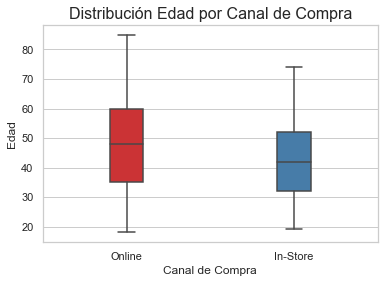

In [57]:
#Utilizamos la librería seaborn
sns.set(style="whitegrid")
#Diagrama de cajas agrupando por región y modo de compra
ax=sns.boxplot(x="In-Store", y="Age",
				data=data, palette="Set1",
				dodge=True, width=0.2)
#Etiquetas en ejes y leyenda
ax.set(xlabel='Canal de Compra',ylabel='Edad')
ax.set_xticklabels(["Online","In-Store"])
#Título
ax.set_title('Distribución Edad por Canal de Compra',fontsize=16)
#Mostrar gráfico
plt.show()

Los datos claramente nos dicen que esa hipótesis es falsa. De hecho, la distribución de edades por canal indica que la tendencia es la contraria. Las compras online son frecuentadas por gente de mayor edad que las compras en tienda.

Ambas cajas indican un amplio rango de edades y muestran clientes de todas las edades a excepción del rango de edad entre 75 y 85. Los clientes de este rango de edad solo realiza compras online y no muestra ni una sola transacción en tienda.

**Los clientes de mayor edad gastan más dinero en electrónica que los jóvenes.**

Mostramos tres gráficos. El primero nos muestra la distribución de la cantidad gastada por transacción para cada rango de edad, el segundo muestra el gasto total resultado de la suma de todas las transacciones realizadas por los clientes con una misma edad mientras que el último muestra el número de transacciones por edad:

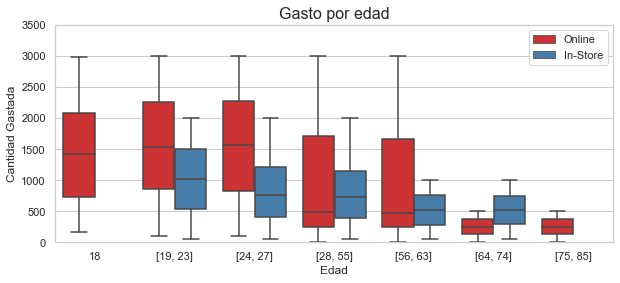

In [58]:
#Valor de la variable In-Store
InStore=['Online','In-Store']
#Incluimos unas filas adicionales con valores nulos para obtener la leyenda correctamente
plt.figure(figsize=(10,4))
#Se crea figura de tamaño dado
#Se grafica el plot anterior para cada una de las regiones
#Utilizamos la librería seaborn
sns.set(style="whitegrid")
#Diagrama de cajas agrupando por región y modo de compra
ax=sns.boxplot(x="Discrete_Age", y="Amount", hue='In-Store',
                data=data, palette="Set1",
                dodge=True,order=np.sort(data['Discrete_Age'].unique()))
#Etiquetas en ejes y leyenda
ax.set(xlabel='Edad',ylabel='Cantidad Gastada')
#Ejes
ax.set(ylim=(0, 3500))
# ax.set(xlim=(-0.5,3.5))
#Leyenda
ax.legend(["Online","In-Store"],title="",)
handler, label = ax.get_legend_handles_labels()
ax.legend(handler, ["Online","In-Store"])
#Título
ax.set_title('Gasto por edad',fontsize=16)
#Mostrar gráfico
plt.show()

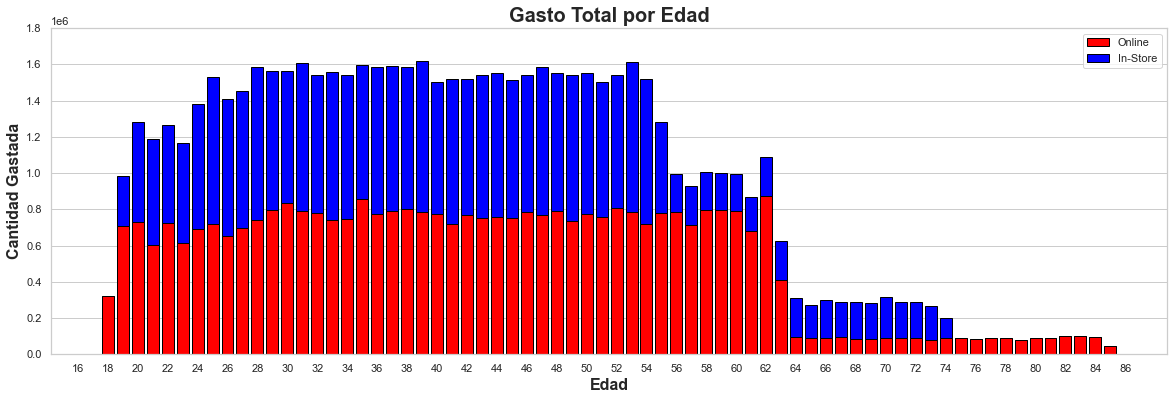

In [59]:
#Se crea figura de tamaño dado
plt.figure(figsize=(20,6))
#Se grafica el plot anterior para cada una de las regiones
#Plot
for i in range (data['Age'].min(),data['Age'].max()+1):
    x_online= data.loc[(data['Age']==i) & (data['In-Store']==0)]['Amount'].sum()
    x_inStore=data.loc[(data['Age']==i) & (data['In-Store']==1)]['Amount'].sum()
    plt.bar(i,x_online,color='red',edgecolor='black')
    plt.bar(i,x_inStore,color='blue',edgecolor='black',bottom=x_online)
#Etiquetas en los ejes
plt.xticks(np.arange(16,87,2))
plt.yticks(np.arange(0,1.81e6,0.2e6))
#Título ejes
plt.xlabel('Edad', fontsize=16,fontweight='bold')
plt.ylabel('Cantidad Gastada', fontsize=16,fontweight='bold')
#Título del plot
plt.title('Gasto Total por Edad',fontsize=20,fontweight='bold')
#Leyenda
plt.legend(['Online','In-Store'],loc=0)
#Subgrid solo horizontales
plt.grid(axis='x')
plt.show()

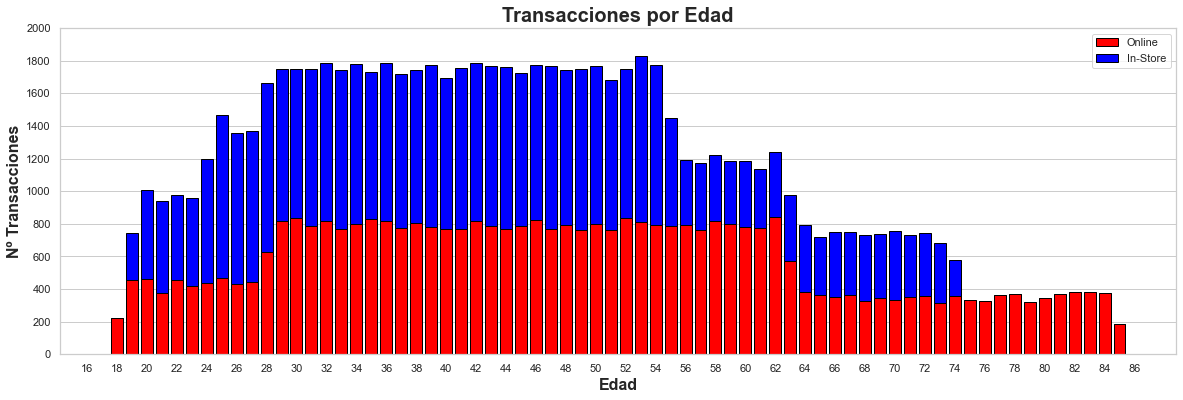

In [60]:
#Se crea figura de tamaño dado
plt.figure(figsize=(20,6))
#Se grafica el plot anterior para cada una de las regiones
#Plot
for i in range (data['Age'].min(),data['Age'].max()+1):
    x_online= data.loc[(data['Age']==i) & (data['In-Store']==0)]['Amount'].count()
    x_inStore=data.loc[(data['Age']==i) & (data['In-Store']==1)]['Amount'].count()
    plt.bar(i,x_online,color='red',edgecolor='black')
    plt.bar(i,x_inStore,color='blue',edgecolor='black',bottom=x_online)
#Etiquetas en los ejes
plt.xticks(np.arange(16,87,2))
plt.yticks(np.arange(0,2001,200))
#Título ejes
plt.xlabel('Edad', fontsize=16,fontweight='bold')
plt.ylabel('Nº Transacciones', fontsize=16,fontweight='bold')
#Título del plot
plt.title('Transacciones por Edad',fontsize=20,fontweight='bold')
#Leyenda
plt.legend(['Online','In-Store'],loc=0)
#Subgrid solo horizontales
plt.grid(axis='x')
plt.show()

Todos los gráficos nos muestran una tendencia única y clara.

Tanto el gasto total como el número de transacciones muestran la misma tendencia y ambas crecen entre los 18 y 28 años para mantenerse constante hasta los 54 aproximadamente. Después se reduce drásticamente en tres escalones situados a los 55, 64 y 75 años aproximadamente.

Además, no solo el gasto por transacción y el número de transacciones es mayor para los clientes más jóvenes, sino que también el gasto por transacción suele ser superior.

Por lo tanto podemos decir que esta hipótesis es cierta.